## Siemens FDA

**Index**

1. Loading the datasets
2. Transposing the time series datasets
3. Merging time series datasets to add additional features
4. Filtering and spliting in Blood and aqueous groups
5. Window extraction
   - 5.1. Validating if there are partial or full missing values after the extraction
   - 5.2 Visualize the origin window intervals in different groups of Features
6. Additional Functions
   7.1. Visualization of plots with raw data after the extraction.
   7.2. Visualization of plots with data centered after the extraction.
7. Visualization of Time Series from the Windows
8. Functional PCA (Visualization of Principal Component Plots in one row)
    - 8.1. Functional PCA characterization function
    - 8.2 Functional PC1 plots (both systems)  Characterization of FPC Scores
    - 8.3 Linear Reregression
9. Fuctional regression
     

The improvements with respect to the code "Siemens_FDA.ipynb" are:
- Change the part in "Filtering and spliting in Bloods and Aqueous groups" for sample the data
- Change the "Merge data" Function in "Additional functions"
- Add 8.3 "Linear Regression" to make statistic summary for PCA(still developing)
- Update 7.2 function "plot_all_time_series_in_group" with a new function to save the photos

# 1. Loading the datasets

In [1]:
#!pip install scikit-fda

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import random
from sklearn.decomposition import PCA
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA
from sklearn.preprocessing import OneHotEncoder
import skfda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FDataBasis, FourierBasis

/var/folders/_c/wdm33bq11dvflh73ffxrd8z40000gn/T/ipykernel_3967/2677705551.py:9: DeprecationWarning: The module "projection" is deprecated. Please use "dim_reduction"
  from skfda.preprocessing.dim_reduction.projection import FPCA


# 2. Transposing the time series datasets

You can change this part based on where you store the data

In [3]:
# Import datasets
sensorA_System1 = pd.read_csv("RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("RawData/Key by TestID.csv", parse_dates=['DateTime'])

# 3. Merging time series datasets to add additional features

In [4]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [5]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

In [6]:
# Create new column to fill fluid temperature NA's
# Note: Fluid temperature: If specified, take as the temperature of the sample fluid. The rest of the system temperature can be taken as ambient temperature.

keyByTestID['Fluid_Temperature_Filled'] = keyByTestID['Fluid Temperature'].combine_first(keyByTestID['AmbientTemperature'])
keyByTestID.head(3)

TestID    FluidType            DateTime          Lot  CardNumber  \
0  3550995  Eurotrol L1 2024-02-07 10:32:15  16-23333-20      302910   
1  3550995  Eurotrol L1 2024-02-07 10:32:15  16-23333-20      302910   
2  3551012  Eurotrol L1 2024-02-07 10:41:33  16-23333-20      303096   

   AgeOfCardInDaysAtTimeOfTest  ReaderSerialNumber  SampleDetectTime  \
0                           70                  73             180.4   
1                           70                  73             180.4   
2                           70                  73             183.2   

   BubbleDetectTime     System    Sensor  AmbientTemperature  \
0             178.8  System 2A  Sensor A             21.2345   
1             178.8  System 2A  Sensor B             21.2345   
2             181.6  System 2A  Sensor A             21.5012   

   Fluid Temperature CardReturnCode ReturnCode Results Error Code  \
0                NaN            NaN    Success            NoError   
1                NaN            NaN    Success            NoError   
2                NaN            NaN    Success            NoError   

  Device Return Code Bge Test ReturnCode  Fluid_Temperature_Filled  
0            NoError             Success                   21.2345  
1            NoError             Success                   21.2345  
2            NoError             Success                   21.5012

In [7]:
# Relabeling System Values
keyByTestID["System"] = keyByTestID["System"].replace({"System 2A":"System 2","System 2B":"System 2"})
keyByTestID.tail(3)

TestID FluidType            DateTime          Lot  CardNumber  \
24255  3518677       HNB 2023-09-19 16:54:21  16-23151-20      302186   
24256  3518678       HNB 2023-09-19 16:54:23  16-23137-20      300820   
24257  3518678       HNB 2023-09-19 16:54:23  16-23137-20      300820   

       AgeOfCardInDaysAtTimeOfTest  ReaderSerialNumber  SampleDetectTime  \
24255                          111                  23             459.0   
24256                          125                  33             459.2   
24257                          125                  33             459.2   

       BubbleDetectTime    System    Sensor  AmbientTemperature  \
24255             454.8  System 2  Sensor B             25.2250   
24256             455.2  System 2  Sensor A             24.4908   
24257             455.2  System 2  Sensor B             24.4908   

       Fluid Temperature CardReturnCode ReturnCode Results Error Code  \
24255               15.0            NaN    Success            NoError   
24256               15.0            NaN    Success            NoError   
24257               15.0            NaN    Success            NoError   

      Device Return Code Bge Test ReturnCode  Fluid_Temperature_Filled  
24255            NoError             Success                      15.0  
24256            NoError             Success                      15.0  
24257            NoError             Success                      15.0

In [8]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 3377)
A2:  (7743, 3368)
B1:  (3375, 3377)
B2:  (7745, 3368)


In [9]:
# Remove the testID only exists in one sensor
# Only run once
A1_Merged = A1_Merged[A1_Merged["TestID"].isin(B1_Merged["TestID"])]
B1_Merged = B1_Merged[B1_Merged["TestID"].isin(A1_Merged["TestID"])]

A2_Merged = A2_Merged[A2_Merged["TestID"].isin(B2_Merged["TestID"])]
B2_Merged = B2_Merged[B2_Merged["TestID"].isin(A2_Merged["TestID"])]
print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3374, 3377)
A2:  (7743, 3368)
B1:  (3374, 3377)
B2:  (7743, 3368)


In [10]:
# Resampling to balance the datasets
def  Resample(Merge_data,FluidType="Blood",random_state = 42):
    """
    Resamples a given dataset based on the specified fluid type.

    Parameters:
    Merge_data (pd.DataFrame): The input dataset containing a 'FluidType' column and a 'TestID' column.
    FluidType (str): The type of fluid to resample. Can be "Blood" or "Aqueous". Default is "Blood".
    random_state (int): The seed for the random number generator to ensure reproducibility. Default is 42.

    Returns:
    list: A list of sampled TestIDs based on the specified fluid type.

    Notes:
    - For "Aqueous" fluid type, the function samples 52 TestIDs for each type in the predefined list of blood types.
    - For "Blood" fluid type, the function samples 30 TestIDs for each type that is not in the predefined list of blood types.
    """
    Fluid = pd.unique(Merge_data['FluidType'])
    Aqueous = ['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5']
    Blood = Fluid[~np.isin(Fluid, Aqueous)]
    SampleID = []
    if FluidType == "Blood":
        for types in Blood:
            ID = list(Merge_data[Merge_data['FluidType'] ==types].sample(n=30, random_state=42).TestID)
            SampleID.extend(ID)
    elif FluidType == "Aqueous":
        for types in Aqueous:
            ID = Merge_data[Merge_data['FluidType'] ==types].sample(n=52, random_state=42).TestID
            SampleID.extend(ID)
    return SampleID

# 4. Filtering and spliting in Blood and Aqueous groups

In [11]:
# Extract Blood
System1_ID_Blood = Resample(A1_Merged,"Blood")
System2_ID_Blood = Resample(A2_Merged,"Blood")

A1_blood_Merged = A1_Merged[A1_Merged["TestID"].isin(System1_ID_Blood)].copy().reset_index(drop=True)
A2_blood_Merged = A2_Merged[A2_Merged["TestID"].isin(System2_ID_Blood)].copy().reset_index(drop=True)
B1_blood_Merged = B1_Merged[B1_Merged["TestID"].isin(System1_ID_Blood)].copy().reset_index(drop=True)
B2_blood_Merged = B2_Merged[B2_Merged["TestID"].isin(System2_ID_Blood)].copy().reset_index(drop=True)


# Extract Aqueous
System1_ID_Aqueous = Resample(A1_Merged,"Aqueous")
System2_ID_Aqueous = Resample(A2_Merged,"Aqueous")

A1_aqueous_Merged = A1_Merged[A1_Merged["TestID"].isin(System1_ID_Aqueous)].copy().reset_index(drop=True)
A2_aqueous_Merged = A2_Merged[A2_Merged["TestID"].isin(System2_ID_Aqueous)].copy().reset_index(drop=True)
B1_aqueous_Merged = B1_Merged[B1_Merged["TestID"].isin(System1_ID_Aqueous)].copy().reset_index(drop=True)
B2_aqueous_Merged = B2_Merged[B2_Merged["TestID"].isin(System2_ID_Aqueous)].copy().reset_index(drop=True)

print("A1_blood_Merged shape:", A1_blood_Merged.shape)
print("A2_blood_Merged shape:", A2_blood_Merged.shape)
print("B1_blood_Merged shape:", B1_blood_Merged.shape)
print("B2_blood_Merged shape:", B2_blood_Merged.shape)

print("A1_aqueous_Merged shape:", A1_aqueous_Merged.shape)
print("A2_aqueous_Merged shape:", A2_aqueous_Merged.shape)
print("B1_aqueous_Merged shape:", B1_aqueous_Merged.shape)
print("B2_aqueous_Merged shape:", B2_aqueous_Merged.shape)

A1_blood_Merged shape: (210, 3377)
A2_blood_Merged shape: (210, 3368)
B1_blood_Merged shape: (210, 3377)
B2_blood_Merged shape: (210, 3368)
A1_aqueous_Merged shape: (208, 3377)
A2_aqueous_Merged shape: (208, 3368)
B1_aqueous_Merged shape: (208, 3377)
B2_aqueous_Merged shape: (208, 3368)


# 5. Window extraction

In [12]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Match window values of Sensor B for each test

# Blood
calDelLimit_sensorB_blood = 20
sampleDelLimit_sensorB_blood = 24
calWindowSize_sensorB_blood = 18
sampleWindowSize_sensorB_blood = 4

# Aqueous
calDelLimit_sensorB_aqueous = 20
sampleDelLimit_sensorB_aqueous = 30
calWindowSize_sensorB_aqueous = 18
sampleWindowSize_sensorB_aqueous = 4

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit_input, cal_window_size_input, sampleDelimit_input, sample_window_size_input):
    """
    Calculate the start and end values for calibration and sample windows. The calculation is based on given start points and delimiters for both windows, as well as the window sizes.

    Parameters:
    -----------
    bubble_start : float
        The starting point for the bubble (reference point for calibration).
    sample_start : float
        The starting point for the sample.
    calDelimit_input : float
        The delimiter value to adjust the starting point of the calibration window.
    cal_window_size_input : float
        The size of the calibration window.
    sampleDelimit_input : float
        The delimiter value to adjust the starting point of the sample window.
    sample_window_size_input : float
        The size of the sample window.

    Returns:
    --------
    tuple of float
        A tuple containing four values:
        - cal_window_start: The starting position of the calibration window, rounded to one decimal place.
        - cal_window_end: The ending position of the calibration window, rounded to one decimal place.
        - sample_window_start: The starting position of the sample window, rounded to one decimal place.
        - sample_window_end: The ending position of the sample window, rounded to one decimal place.
    """
    cal_window_start = bubble_start - calDelimit_input
    cal_window_end = cal_window_start + cal_window_size_input
    sample_window_start = sample_start + sampleDelimit_input
    sample_window_end = sample_window_start + sample_window_size_input
    return round(cal_window_start,1), round(cal_window_end,1), round(sample_window_start,1), round(sample_window_end,1)

# Sensor A
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end


# Sensor A - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_blood_Merged['cal_window_start']=cal_window_start
A1_blood_Merged['cal_window_end']=cal_window_end
A1_blood_Merged['sample_window_start']=sample_window_start
A1_blood_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_blood_Merged['cal_window_start']=cal_window_start
A2_blood_Merged['cal_window_end']=cal_window_end
A2_blood_Merged['sample_window_start']=sample_window_start
A2_blood_Merged['sample_window_end']=sample_window_end


# Sensor A - aqueous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_aqueous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_aqueous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_aqueous_Merged['cal_window_start']=cal_window_start
A1_aqueous_Merged['cal_window_end']=cal_window_end
A1_aqueous_Merged['sample_window_start']=sample_window_start
A1_aqueous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_aqueous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_aqueous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_aqueous_Merged['cal_window_start']=cal_window_start
A2_aqueous_Merged['cal_window_end']=cal_window_end
A2_aqueous_Merged['sample_window_start']=sample_window_start
A2_aqueous_Merged['sample_window_end']=sample_window_end

# Sensor B - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B1_blood_Merged['cal_window_start']=cal_window_start
B1_blood_Merged['cal_window_end']=cal_window_end
B1_blood_Merged['sample_window_start']=sample_window_start
B1_blood_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B2_blood_Merged['cal_window_start']=cal_window_start
B2_blood_Merged['cal_window_end']=cal_window_end
B2_blood_Merged['sample_window_start']=sample_window_start
B2_blood_Merged['sample_window_end']=sample_window_end


# Sensor B - aqueous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_aqueous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_aqueous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B1_aqueous_Merged['cal_window_start']=cal_window_start
B1_aqueous_Merged['cal_window_end']=cal_window_end
B1_aqueous_Merged['sample_window_start']=sample_window_start
B1_aqueous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_aqueous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_aqueous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B2_aqueous_Merged['cal_window_start']=cal_window_start
B2_aqueous_Merged['cal_window_end']=cal_window_end
B2_aqueous_Merged['sample_window_start']=sample_window_start
B2_aqueous_Merged['sample_window_end']=sample_window_end

In [13]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    """
    Extracts calibration and sample window data from a given row of time series data.

    Parameters:
    row (pd.Series): A pandas Series object containing time series data and window start/end times.
        The Series should have the following structure:
        - 'cal_window_start': The start time for the calibration window.
        - 'cal_window_end': The end time for the calibration window.
        - 'sample_window_start': The start time for the sample window.
        - 'sample_window_end': The end time for the sample window.
        - The index from position 19 to -4 should contain the timestamps (as float) of the time series data.

    Returns:
    tuple: A tuple containing two pandas Series:
        - The first Series corresponds to the data within the calibration window.
        - The second Series corresponds to the data within the sample window.
    """
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[19:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# Sensor A

A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID'].astype(int)
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)

A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID'].astype(int)
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor A - Blood

A1_blood_cal_window = []
A1_blood_sample_window = []
for i in range(len(A1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(A1_blood_Merged.iloc[i, :])
    A1_blood_cal_window.append(cal_window.values)
    A1_blood_sample_window.append(sample_window.values)
A1_blood_cal_window = pd.DataFrame(A1_blood_cal_window)
A1_blood_sample_window = pd.DataFrame(A1_blood_sample_window)
A1_blood_cal_window['TestID'] = A1_blood_sample_window['TestID'] = A1_blood_Merged['TestID'].astype(int)
A1_blood_sample_window.set_index('TestID',inplace=True)
A1_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor A - aqueous

A1_aqueous_cal_window = []
A1_aqueous_sample_window = []
for i in range(len(A1_aqueous_Merged)):
    cal_window, sample_window = calculate_window_data(A1_aqueous_Merged.iloc[i, :])
    A1_aqueous_cal_window.append(cal_window.values)
    A1_aqueous_sample_window.append(sample_window.values)
A1_aqueous_cal_window = pd.DataFrame(A1_aqueous_cal_window)
A1_aqueous_sample_window = pd.DataFrame(A1_aqueous_sample_window)
A1_aqueous_cal_window['TestID'] = A1_aqueous_sample_window['TestID'] = A1_aqueous_Merged['TestID'].astype(int)
A1_aqueous_sample_window.set_index('TestID',inplace=True)
A1_aqueous_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A - Blood

A2_blood_cal_window = []
A2_blood_sample_window = []
for i in range(len(A2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(A2_blood_Merged.iloc[i, :])
    A2_blood_cal_window.append(cal_window.values)
    A2_blood_sample_window.append(sample_window.values)
A2_blood_cal_window = pd.DataFrame(A2_blood_cal_window)
A2_blood_sample_window = pd.DataFrame(A2_blood_sample_window)
A2_blood_cal_window['TestID'] = A2_blood_sample_window['TestID'] = A2_blood_Merged['TestID'].astype(int)
A2_blood_sample_window.set_index('TestID',inplace=True)
A2_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A - aqueous

A2_aqueous_cal_window = []
A2_aqueous_sample_window = []
for i in range(len(A2_aqueous_Merged)):
    cal_window, sample_window = calculate_window_data(A2_aqueous_Merged.iloc[i, :])
    A2_aqueous_cal_window.append(cal_window.values)
    A2_aqueous_sample_window.append(sample_window.values)
A2_aqueous_cal_window = pd.DataFrame(A2_aqueous_cal_window)
A2_aqueous_sample_window = pd.DataFrame(A2_aqueous_sample_window)
A2_aqueous_cal_window['TestID'] = A2_aqueous_sample_window['TestID'] = A2_aqueous_Merged['TestID'].astype(int)
A2_aqueous_sample_window.set_index('TestID',inplace=True)
A2_aqueous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Blood

B1_blood_cal_window = []
B1_blood_sample_window = []
for i in range(len(B1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B1_blood_Merged.iloc[i, :])
    B1_blood_cal_window.append(cal_window.values)
    B1_blood_sample_window.append(sample_window.values)
B1_blood_cal_window = pd.DataFrame(B1_blood_cal_window)
B1_blood_sample_window = pd.DataFrame(B1_blood_sample_window)
B1_blood_cal_window['TestID'] = B1_blood_sample_window['TestID'] = B1_blood_Merged['TestID'].astype(int)
B1_blood_sample_window.set_index('TestID',inplace=True)
B1_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor B - Blood

B2_blood_cal_window = []
B2_blood_sample_window = []
for i in range(len(B2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B2_blood_Merged.iloc[i, :])
    B2_blood_cal_window.append(cal_window.values)
    B2_blood_sample_window.append(sample_window.values)
B2_blood_cal_window = pd.DataFrame(B2_blood_cal_window)
B2_blood_sample_window = pd.DataFrame(B2_blood_sample_window)
B2_blood_cal_window['TestID'] = B2_blood_sample_window['TestID'] = B2_blood_Merged['TestID'].astype(int)
B2_blood_sample_window.set_index('TestID',inplace=True)
B2_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - aqueous

B1_aqueous_cal_window = []
B1_aqueous_sample_window = []
for i in range(len(B1_aqueous_Merged)):
    cal_window, sample_window = calculate_window_data(B1_aqueous_Merged.iloc[i, :])
    B1_aqueous_cal_window.append(cal_window.values)
    B1_aqueous_sample_window.append(sample_window.values)
B1_aqueous_cal_window = pd.DataFrame(B1_aqueous_cal_window)
B1_aqueous_sample_window = pd.DataFrame(B1_aqueous_sample_window)
B1_aqueous_cal_window['TestID'] = B1_aqueous_sample_window['TestID'] = B1_aqueous_Merged['TestID'].astype(int)
B1_aqueous_sample_window.set_index('TestID',inplace=True)
B1_aqueous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Aqueous

B2_aqueous_cal_window = []
B2_aqueous_sample_window = []
for i in range(len(B2_aqueous_Merged)):
    cal_window, sample_window = calculate_window_data(B2_aqueous_Merged.iloc[i, :])
    B2_aqueous_cal_window.append(cal_window.values)
    B2_aqueous_sample_window.append(sample_window.values)
B2_aqueous_cal_window = pd.DataFrame(B2_aqueous_cal_window)
B2_aqueous_sample_window = pd.DataFrame(B2_aqueous_sample_window)
B2_aqueous_cal_window['TestID'] = B2_aqueous_sample_window['TestID'] = B2_aqueous_Merged['TestID'].astype(int)
B2_aqueous_sample_window.set_index('TestID',inplace=True)
B2_aqueous_cal_window.set_index('TestID',inplace=True)

## 5.1. Validating if there are partial or full missing values after the extraction

In [14]:
A1_cal_window_drop_index = A1_cal_window.loc[A1_cal_window.isna().sum(axis=1)!=0].index
A2_cal_window_drop_index = A2_cal_window.loc[A2_cal_window.isna().sum(axis=1)!=0].index

A1_blood_cal_window_drop_index = A1_blood_cal_window.loc[A1_blood_cal_window.isna().sum(axis=1)!=0].index
A1_aqueous_cal_window_drop_index = A1_aqueous_cal_window.loc[A1_aqueous_cal_window.isna().sum(axis=1)!=0].index
A2_blood_cal_window_drop_index = A2_blood_cal_window.loc[A2_blood_cal_window.isna().sum(axis=1)!=0].index
A2_aqueous_cal_window_drop_index = A2_aqueous_cal_window.loc[A2_aqueous_cal_window.isna().sum(axis=1)!=0].index

B1_blood_cal_window_drop_index = B1_blood_cal_window.loc[B1_blood_cal_window.isna().sum(axis=1)!=0].index
B1_aqueous_cal_window_drop_index = B1_aqueous_cal_window.loc[B1_aqueous_cal_window.isna().sum(axis=1)!=0].index
B2_blood_cal_window_drop_index = B2_blood_cal_window.loc[B2_blood_cal_window.isna().sum(axis=1)!=0].index
B2_aqueous_cal_window_drop_index = B2_aqueous_cal_window.loc[B2_aqueous_cal_window.isna().sum(axis=1)!=0].index

A1_sample_window_drop_index = A1_sample_window.loc[A1_sample_window.isna().sum(axis=1)!=0].index
A2_sample_window_drop_index = A2_sample_window.loc[A2_sample_window.isna().sum(axis=1)!=0].index

A1_blood_sample_window_drop_index = A1_blood_sample_window.loc[A1_blood_sample_window.isna().sum(axis=1)!=0].index
A1_aqueous_sample_window_drop_index = A1_aqueous_sample_window.loc[A1_aqueous_sample_window.isna().sum(axis=1)!=0].index
A2_blood_sample_window_drop_index = A2_blood_sample_window.loc[A2_blood_sample_window.isna().sum(axis=1)!=0].index
A2_aqueous_sample_window_drop_index = A2_aqueous_sample_window.loc[A2_aqueous_sample_window.isna().sum(axis=1)!=0].index

B1_blood_sample_window_drop_index = B1_blood_sample_window.loc[B1_blood_sample_window.isna().sum(axis=1)!=0].index
B1_aqueous_sample_window_drop_index = B1_aqueous_sample_window.loc[B1_aqueous_sample_window.isna().sum(axis=1)!=0].index
B2_blood_sample_window_drop_index = B2_blood_sample_window.loc[B2_blood_sample_window.isna().sum(axis=1)!=0].index
B2_aqueous_sample_window_drop_index = B2_aqueous_sample_window.loc[B2_aqueous_sample_window.isna().sum(axis=1)!=0].index

# Check if missing values in different windows is different
print("The missing value in calibration window:",A1_cal_window_drop_index)
print("The missing value in sample window:",A1_sample_window_drop_index)
print("The missing value in calibration window:",A2_cal_window_drop_index)
print("The missing value in sample window:",A2_sample_window_drop_index)

print("The missing value in calibration window:",B1_blood_cal_window_drop_index)
print("The missing value in sample window:",B1_blood_sample_window_drop_index)
print("The missing value in calibration window:",B2_blood_cal_window_drop_index)
print("The missing value in sample window:",B2_blood_sample_window_drop_index)

The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')


In [15]:
# Shape of the subsets of time series after the extraction from the windows

# Cal Window
print('Shape of the time series after extraction')
print('A1_blood_cal_window: ', A1_blood_cal_window.shape)
print('A1_aqueous_cal_window: ', A1_aqueous_cal_window.shape)
print('A2_blood_cal_window: ', A2_blood_cal_window.shape)
print('A2_aqueous_cal_window: ', A2_aqueous_cal_window.shape)
print('B1_blood_cal_window: ', B1_blood_cal_window.shape)
print('B1_aqueous_cal_window: ', B1_aqueous_cal_window.shape)
print('B2_blood_cal_window: ', B2_blood_cal_window.shape)
print('B2_aqueous_cal_window: ', B2_aqueous_cal_window.shape)

# Sample Window
print('A1_blood_sample_window: ', A1_blood_sample_window.shape)
print('A1_aqueous_sample_window: ', A1_aqueous_sample_window.shape)
print('A2_blood_sample_window: ', A2_blood_sample_window.shape)
print('A2_aqueous_sample_window: ', A2_aqueous_sample_window.shape)
print('B1_blood_sample_window: ', B1_blood_sample_window.shape)
print('B1_aqueous_sample_window: ', B1_aqueous_sample_window.shape)
print('B2_blood_sample_window: ', B2_blood_sample_window.shape)
print('B2_aqueous_sample_window: ', B2_aqueous_sample_window.shape)

Shape of the time series after extraction
A1_blood_cal_window:  (210, 41)
A1_aqueous_cal_window:  (208, 41)
A2_blood_cal_window:  (210, 41)
A2_aqueous_cal_window:  (208, 41)
B1_blood_cal_window:  (210, 91)
B1_aqueous_cal_window:  (208, 91)
B2_blood_cal_window:  (210, 91)
B2_aqueous_cal_window:  (208, 91)
A1_blood_sample_window:  (210, 26)
A1_aqueous_sample_window:  (208, 26)
A2_blood_sample_window:  (210, 26)
A2_aqueous_sample_window:  (208, 26)
B1_blood_sample_window:  (210, 21)
B1_aqueous_sample_window:  (208, 21)
B2_blood_sample_window:  (210, 21)
B2_aqueous_sample_window:  (208, 21)



# 6. Additional functions

In [16]:
def plot_all_time_series(df, title):
    """
    Plots all time series data from a DataFrame.

    Parameters:
    df (pd.DataFrame): A pandas DataFrame where each row represents a time series. The values in the rows are the
                       data points of the time series.
    title (str): The title for the plot.

    Returns:
    Display the chart with all the time series in one plot.
    """
    plt.figure(figsize=(6, 4))

    # Generate colors using a colormap
    num_lines = len(df)
    colors = plt.cm.Greys(np.linspace(0, 1, num_lines))

    # Plot each row with a different color
    for index, (i, row) in enumerate(df.iterrows()):
        plt.plot(row.values, label=f'Time Series {i + 1}', color=colors[index])

    plt.ylabel('Electrical signals (mV)')
    plt.xlabel('Time (s)')
    plt.title(title)
    plt.show()

In [17]:
def plot_all_time_series_and_mean_fpca(df, title, x_new, y_new):
    """
    Plots all time series data from a DataFrame and adds a new curve.

    Parameters:
    df (pd.DataFrame): A pandas DataFrame where each row represents a time series. The values in the rows are the
                       data points of the time series.
    title (str): The title for the plot.
    x_new (array-like): The x values for the mean from the fpca.
    y_new (array-like): The y values for the mean from the fpca.

    Returns:
    Displays the chart with all the time series and the new curve in one plot.
    """
    plt.figure(figsize=(6, 4))

    # Generate colors using a colormap
    num_lines = len(df)
    colors = plt.cm.Greys(np.linspace(0, 1, num_lines))

    # Plot each row with a different color
    for index, (i, row) in enumerate(df.iterrows()):
        plt.plot(row.values, label=f'Time Series {i + 1}', color=colors[index])

    # Add the new curve
    plt.plot(x_new, y_new, label='New Curve', color='red', linewidth=2)
    #plt.legend(title="Mean") 
    plt.ylabel('Electrical signals (mV)')
    plt.xlabel('Time (s)')
    plt.title(title)
    plt.show()

In [18]:
def plot_all_time_series_in_group(df1, df2, df3, df4, lab, name1, name2, name3, name4):
    """
    Plot time series data from four dataframes in a 2x2 grid of subplots.

    Parameters:
    df1 (DataFrame): The first dataframe containing time series data.
    df2 (DataFrame): The second dataframe containing time series data.
    df3 (DataFrame): The third dataframe containing time series data.
    df4 (DataFrame): The fourth dataframe containing time series data.
    lab (str): The column name used for labeling the series.
    name1 (str): The title for the first subplot.
    name2 (str): The title for the second subplot.
    name3 (str): The title for the third subplot.
    name4 (str): The title for the fourth subplot.

    Returns:
    None: This function displays the plots of the time series data.
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # Create a 2x2 grid of subplots

    # Create a color mapping for each unique label
    unique_labels = sorted(pd.concat([df1[lab], df2[lab], df3[lab], df4[lab]]).unique())
    colors = {label: plt.cm.tab10(i) for i, label in enumerate(unique_labels)}

    def plot_time_series(df, ax, subplot_title):
        """
        Plot the time series data on a given axis with a specified title.

        Parameters:
        df (DataFrame): The dataframe containing time series data.
        ax (Axes): The subplot axis to plot on.
        subplot_title (str): The title for the subplot.

        Returns:
        None
        """
        for index, row in df.iterrows():
            label = row[lab]
            ax.plot(range(len(row) - 3), row[:-3], label=label, color=colors[label])
        ax.set_ylabel('Electrical signals (mV)')
        ax.set_xlabel('Time (s)')

        # Create a unique legend with fixed order
        handles, labels = ax.get_legend_handles_labels()
        legend_handles = [handles[labels.index(label)] for label in unique_labels if label in labels]

        ax.legend(legend_handles, unique_labels, title=f'{lab}')
        ax.set_title(subplot_title)

    # Plot time series data for each dataframe in the respective subplot
    plot_time_series(df1, axs[0, 0], f'{name1}')
    plot_time_series(df2, axs[0, 1], f'{name2}')
    plot_time_series(df3, axs[1, 0], f'{name3}')
    plot_time_series(df4, axs[1, 1], f'{name4}')

    # Set the overall title for the figure
    fig.suptitle(f'Windows series in different {lab}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
    plt.savefig(f'{name1}.png')
    plt.show()


In [19]:
def Merge_data(windows, merge_data):
    """
    Merge the 'windows' dataframe with selected columns from the 'merge' dataframe,
    categorize 'AgeOfCardInDaysAtTimeOfTest' and 'AmbientTemperature' into bins,
    and return a random sample of the combined dataframe.

    Parameters:
    windows (DataFrame): The primary dataframe to merge.
    merge (DataFrame): The dataframe containing the additional columns to merge.

    Returns:
    DataFrame: A random sample of 500 rows from the merged dataframe.
    """

    # Merge the two dataframes on their indices
    window_combine = windows.merge(
        merge_data[["FluidType", "AgeOfCardInDaysAtTimeOfTest", "AmbientTemperature"]],
        how="inner",
        left_index=True,
        right_index=True
    )

    # Categorize 'AgeOfCardInDaysAtTimeOfTest' into bins
    window_combine["AgeOfCardInDaysAtTimeOfTest"] = pd.cut(
        window_combine["AgeOfCardInDaysAtTimeOfTest"],
        bins=[0, 9, 28, 56, 84, 112, 140, 168, 196, 224, 252],
        labels=['Below 9', '9-28', '28-56', '56-84', '84-112', '112-140', '140-168', '168-196', '196-224', '224-252']
    )

    # Categorize 'AmbientTemperature' into bins
    window_combine["AmbientTemperature"] = pd.cut(
        window_combine["AmbientTemperature"],
        bins=[-1, 20, 26, 100],
        labels=['Below 20', '20-26', 'Above 26']
    )


    return window_combine


## 7.1 Combination of the time series and features in the same table

We have the xx_xx_window (e.g. B2_blood_cal_window) variable which contains the time series value and also xx_Merged (e.g. A1_Merged) which includes the features [Card_Age, Temperature, Fluid_Type].

 In the following part, we try to combine them for the visualization and regression

In [20]:
# Set index for Merge datasets
A1_Merged.set_index("TestID", inplace=True)
A2_Merged.set_index("TestID", inplace=True)

A1_blood_Merged.set_index("TestID", inplace=True)
A2_blood_Merged.set_index("TestID", inplace=True)
A1_aqueous_Merged.set_index("TestID", inplace=True)
A2_aqueous_Merged.set_index("TestID", inplace=True)

B1_Merged.set_index("TestID", inplace=True)
B2_Merged.set_index("TestID", inplace=True)

B1_blood_Merged.set_index("TestID", inplace=True)
B2_blood_Merged.set_index("TestID", inplace=True)
B1_aqueous_Merged.set_index("TestID", inplace=True)
B2_aqueous_Merged.set_index("TestID", inplace=True)

In [21]:
# Combine data
A1_cal_window_combine = Merge_data(A1_cal_window,A1_Merged)
A2_cal_window_combine = Merge_data(A2_cal_window,A2_Merged)
A1_blood_cal_window_combine = Merge_data(A1_blood_cal_window,A1_blood_Merged)
A2_blood_cal_window_combine = Merge_data(A2_blood_cal_window,A2_blood_Merged)
A1_aqueous_cal_window_combine = Merge_data(A1_aqueous_cal_window,A1_aqueous_Merged)
A2_aqueous_cal_window_combine = Merge_data(A2_aqueous_cal_window,A2_aqueous_Merged)

B1_blood_cal_window_combine = Merge_data(B1_blood_cal_window,B1_blood_Merged)
B2_blood_cal_window_combine = Merge_data(B2_blood_cal_window,B2_blood_Merged)
B1_aqueous_cal_window_combine = Merge_data(B1_aqueous_cal_window,B1_aqueous_Merged)
B2_aqueous_cal_window_combine = Merge_data(B2_aqueous_cal_window,B2_aqueous_Merged)

A1_cal_window_combine = Merge_data(A1_cal_window,A1_Merged)
A2_cal_window_combine = Merge_data(A2_cal_window,A2_Merged)
A1_blood_cal_window_combine = Merge_data(A1_blood_cal_window,A1_blood_Merged)
A2_blood_cal_window_combine = Merge_data(A2_blood_cal_window,A2_blood_Merged)
A1_aqueous_cal_window_combine = Merge_data(A1_aqueous_cal_window,A1_aqueous_Merged)
A2_aqueous_cal_window_combine = Merge_data(A2_aqueous_cal_window,A2_aqueous_Merged)

B1_blood_cal_window_combine = Merge_data(B1_blood_cal_window,B1_blood_Merged)
B2_blood_cal_window_combine = Merge_data(B2_blood_cal_window,B2_blood_Merged)
B1_aqueous_cal_window_combine = Merge_data(B1_aqueous_cal_window,B1_aqueous_Merged)
B2_aqueous_cal_window_combine = Merge_data(B2_aqueous_cal_window,B2_aqueous_Merged)

## Sample window
A1_sample_window_combine = Merge_data(A1_sample_window,A1_Merged)
A2_sample_window_combine = Merge_data(A2_sample_window,A2_Merged)
A1_blood_sample_window_combine = Merge_data(A1_blood_sample_window,A1_blood_Merged)
A2_blood_sample_window_combine = Merge_data(A2_blood_sample_window,A2_blood_Merged)
A1_aqueous_sample_window_combine = Merge_data(A1_aqueous_sample_window,A1_aqueous_Merged)
A2_aqueous_sample_window_combine = Merge_data(A2_aqueous_sample_window,A2_aqueous_Merged)

B1_blood_sample_window_combine = Merge_data(B1_blood_sample_window,B1_blood_Merged)
B2_blood_sample_window_combine = Merge_data(B2_blood_sample_window,B2_blood_Merged)
B1_aqueous_sample_window_combine = Merge_data(B1_aqueous_sample_window,B1_aqueous_Merged)
B2_aqueous_sample_window_combine = Merge_data(B2_aqueous_sample_window,B2_aqueous_Merged)

A1_sample_window_combine = Merge_data(A1_sample_window,A1_Merged)
A2_sample_window_combine = Merge_data(A2_sample_window,A2_Merged)
A1_blood_sample_window_combine = Merge_data(A1_blood_sample_window,A1_blood_Merged)
A2_blood_sample_window_combine = Merge_data(A2_blood_sample_window,A2_blood_Merged)
A1_aqueous_sample_window_combine = Merge_data(A1_aqueous_sample_window,A1_aqueous_Merged)
A2_aqueous_sample_window_combine = Merge_data(A2_aqueous_sample_window,A2_aqueous_Merged)

B1_blood_sample_window_combine = Merge_data(B1_blood_sample_window,B1_blood_Merged)
B2_blood_sample_window_combine = Merge_data(B2_blood_sample_window,B2_blood_Merged)
B1_aqueous_sample_window_combine = Merge_data(B1_aqueous_sample_window,B1_aqueous_Merged)
B2_aqueous_sample_window_combine = Merge_data(B2_aqueous_sample_window,B2_aqueous_Merged)

In [22]:
A1_blood_cal_window[A1_blood_cal_window[0]>100]

0         1         2         3         4         5   \
TestID                                                                 
12431655  104.1108  104.1147  104.1046  104.0804  104.0909  104.0813   
12431672  111.6533  111.6455  111.6330  111.6339  111.6190  111.6339   

                6         7         8         9   ...        31        32  \
TestID                                            ...                       
12431655  104.0798  104.0921  104.0775  104.0533  ...  103.9836  103.9565   
12431672  111.6256  111.6035  111.6080  111.6133  ...  111.4703  111.4941   

                33        34        35        36        37        38  \
TestID                                                                 
12431655  103.9642  103.9621  103.9431  103.9496  103.9374  103.9347   
12431672  111.4610  111.4697  111.4586  111.4440  111.4613  111.4384   

                39        40  
TestID                        
12431655  103.9428  103.9282  
12431672  111.4432  111.4369  

[2 rows x 41 columns]

## 7.2 Visualize the windows using the center data (scaling type 1)

### 7.2.1 Fuild type

#### System 1 and System 2: Sensor A - Blood - Cal and Sample Windows

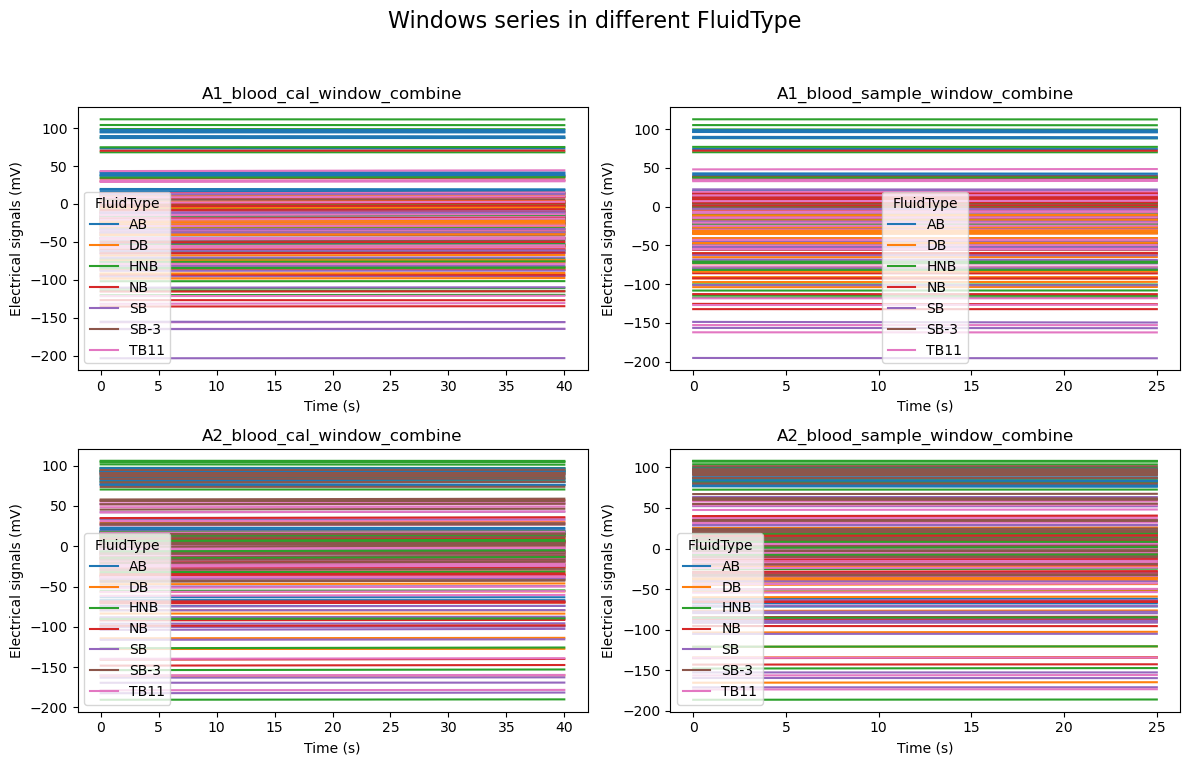

In [23]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(A1_blood_cal_window_combine, A1_blood_sample_window_combine, A2_blood_cal_window_combine, A2_blood_sample_window_combine,"FluidType","A1_blood_cal_window_combine", "A1_blood_sample_window_combine","A2_blood_cal_window_combine", "A2_blood_sample_window_combine")


#### System 1 and System 2: Sensor A - Aqueous - Cal and Sample Windows

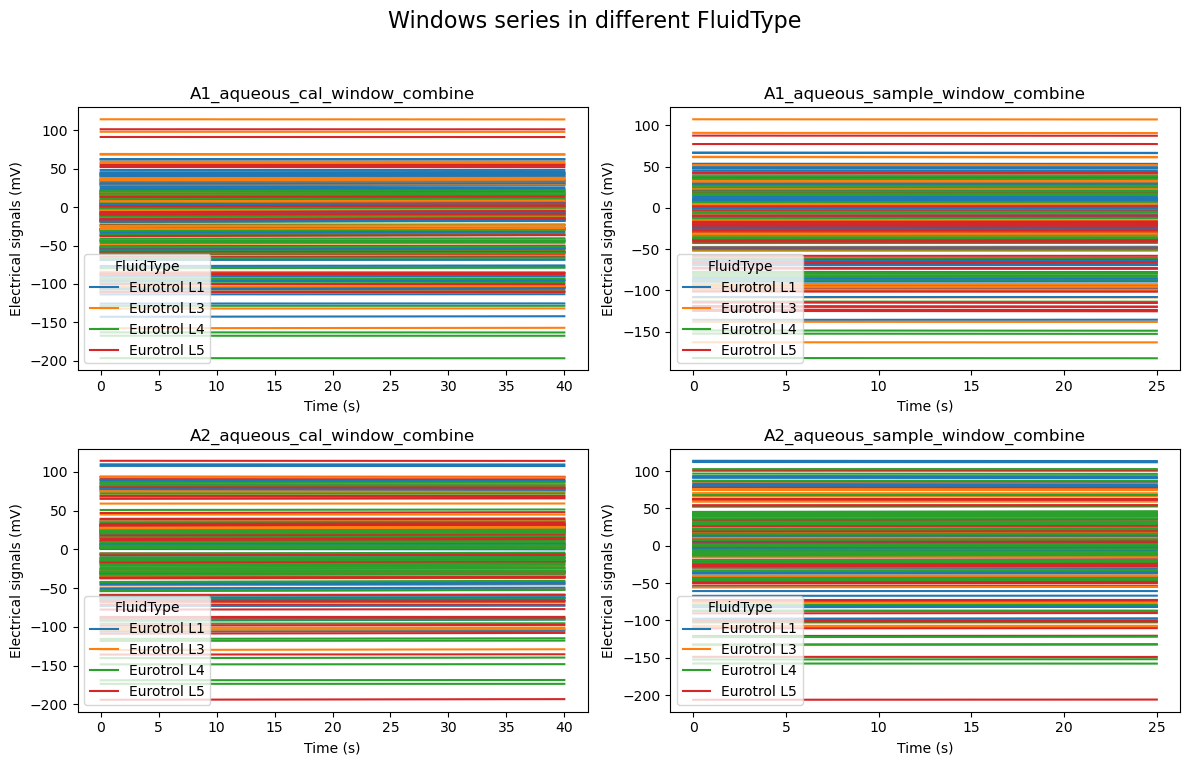

In [24]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(A1_aqueous_cal_window_combine, A1_aqueous_sample_window_combine,A2_aqueous_cal_window_combine, A2_aqueous_sample_window_combine,"FluidType","A1_aqueous_cal_window_combine", "A1_aqueous_sample_window_combine","A2_aqueous_cal_window_combine", "A2_aqueous_sample_window_combine")


#### System 1 and System 2: Sensor B - Blood - Cal and Sample Windows

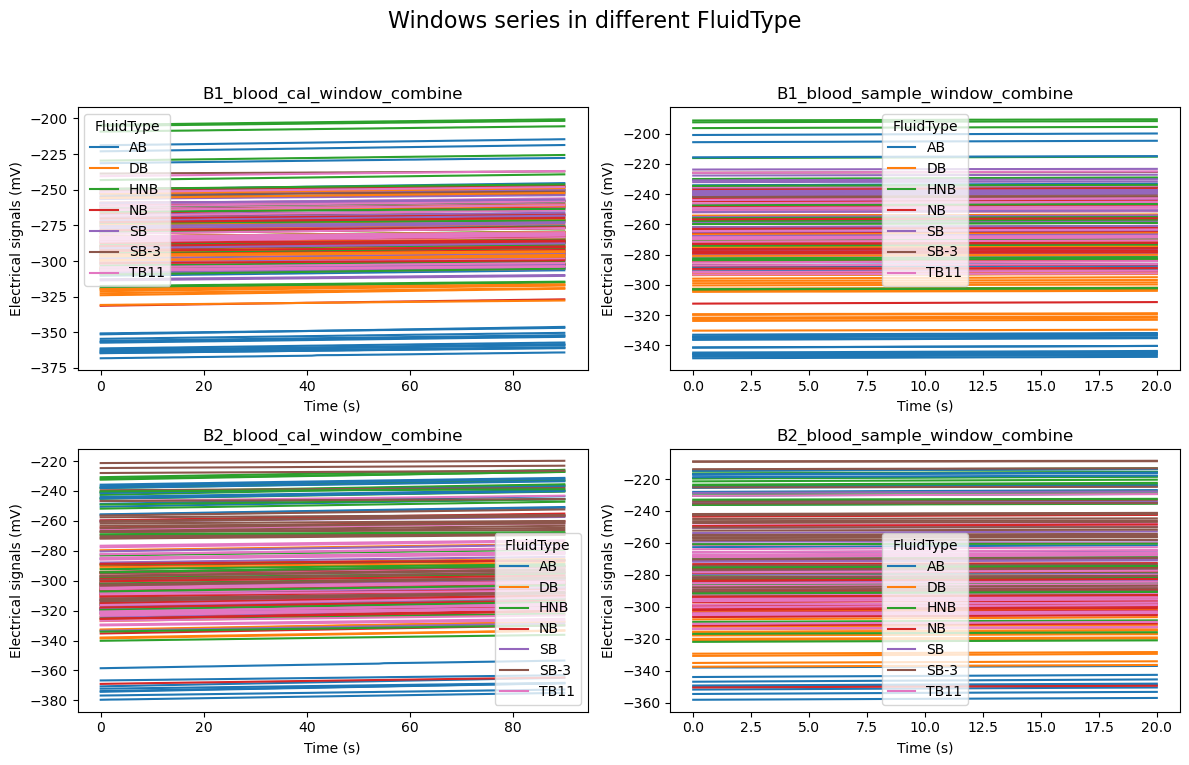

In [25]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(B1_blood_cal_window_combine, B1_blood_sample_window_combine, B2_blood_cal_window_combine, B2_blood_sample_window_combine, "FluidType", "B1_blood_cal_window_combine", "B1_blood_sample_window_combine", "B2_blood_cal_window_combine", "B2_blood_sample_window_combine")


#### System 1 and System 2: Sensor B - Aqueous - Cal and Sample Windows

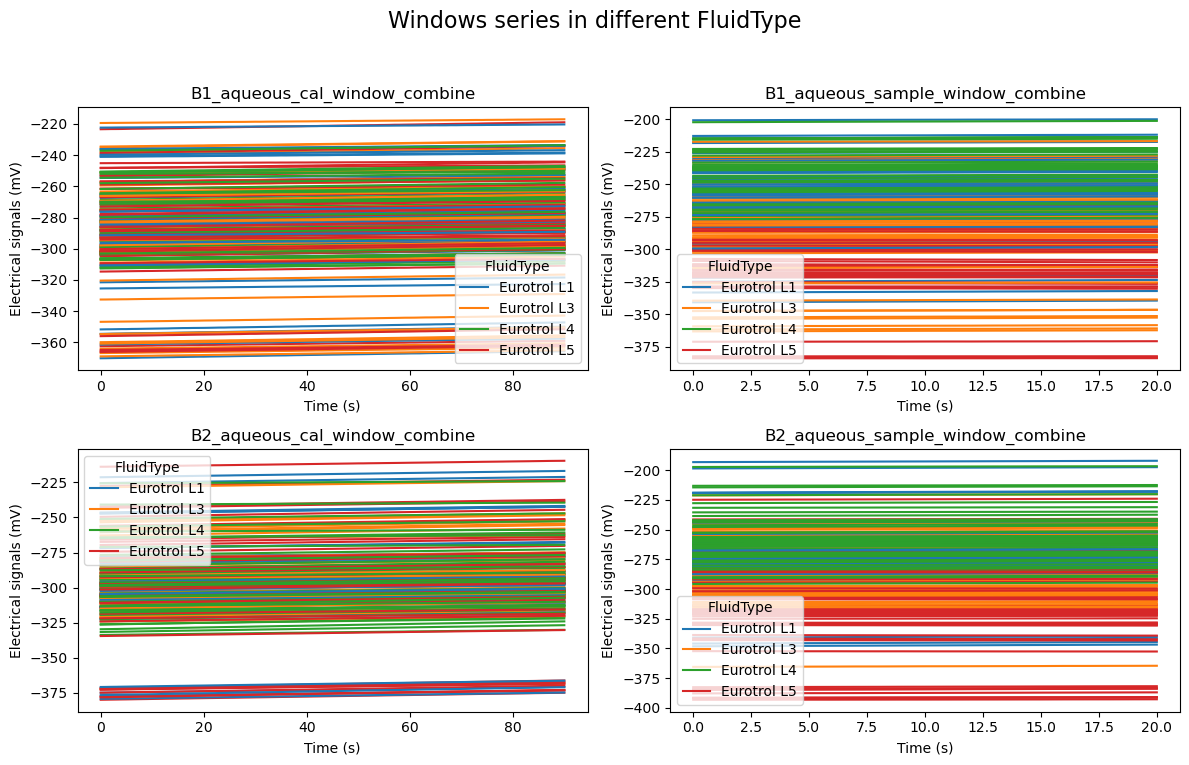

In [26]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(B1_aqueous_cal_window_combine, B1_aqueous_sample_window_combine, B2_aqueous_cal_window_combine, B2_aqueous_sample_window_combine, "FluidType", "B1_aqueous_cal_window_combine", "B1_aqueous_sample_window_combine", "B2_aqueous_cal_window_combine", "B2_aqueous_sample_window_combine")


### 7.2.2 Card Age

#### System 1 and System 2: Sensor A - Blood - Cal and Sample Windows

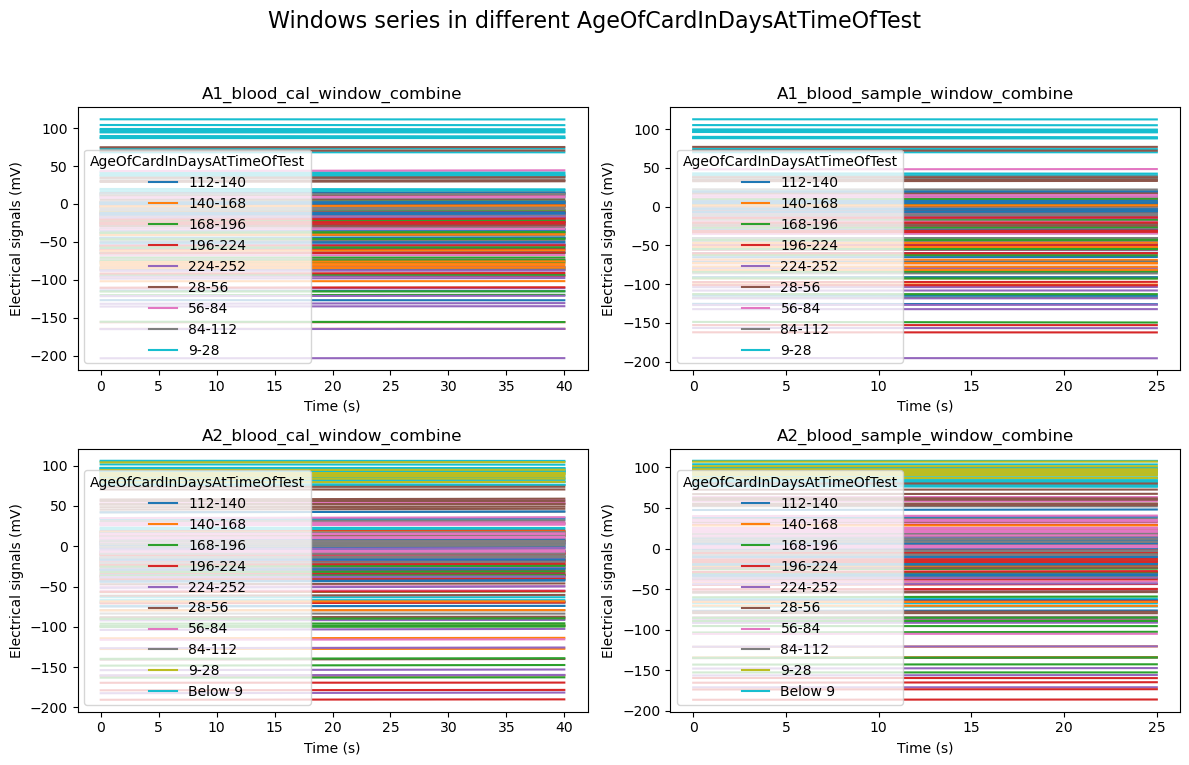

In [27]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(A1_blood_cal_window_combine, A1_blood_sample_window_combine,A2_blood_cal_window_combine, A2_blood_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest","A1_blood_cal_window_combine", "A1_blood_sample_window_combine","A2_blood_cal_window_combine", "A2_blood_sample_window_combine")

#### System 1 and System 2: Sensor A - Aqueous - Cal and Sample Windows

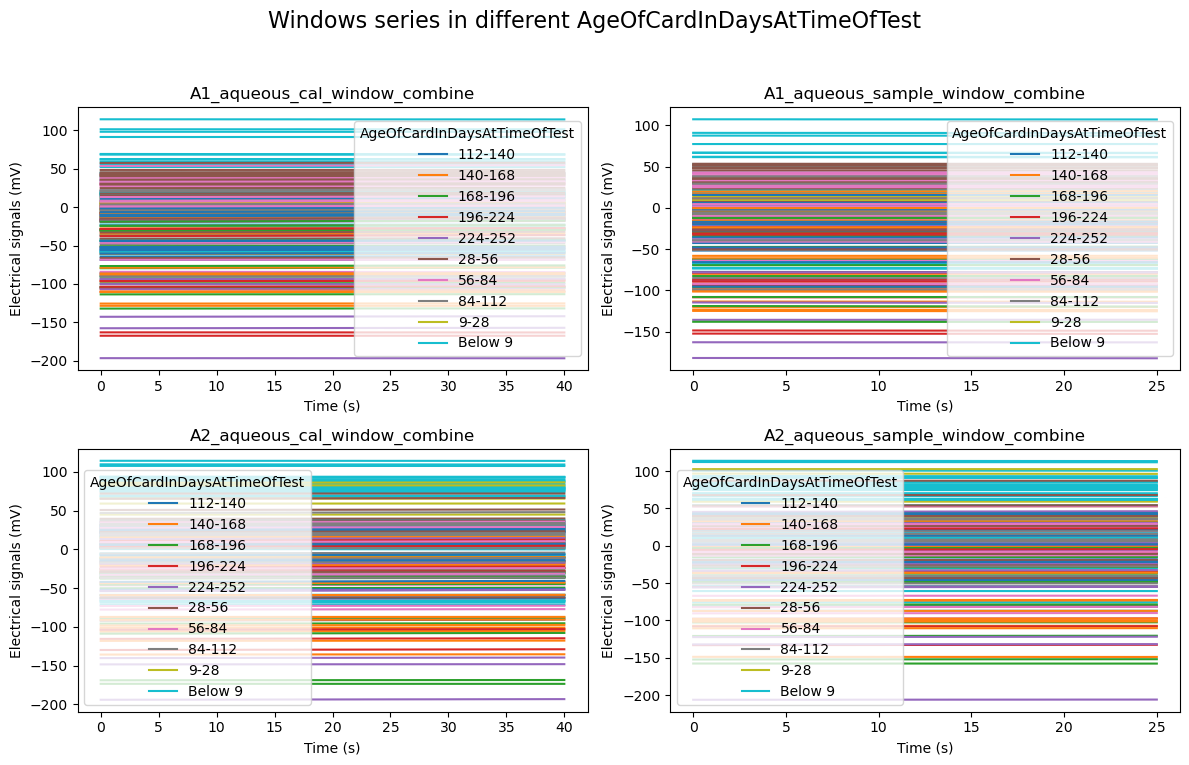

In [28]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(A1_aqueous_cal_window_combine, A1_aqueous_sample_window_combine,A2_aqueous_cal_window_combine, A2_aqueous_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest","A1_aqueous_cal_window_combine", "A1_aqueous_sample_window_combine","A2_aqueous_cal_window_combine", "A2_aqueous_sample_window_combine")


#### System 1 and System 2: Sensor B - Blood - Cal and Sample Windows

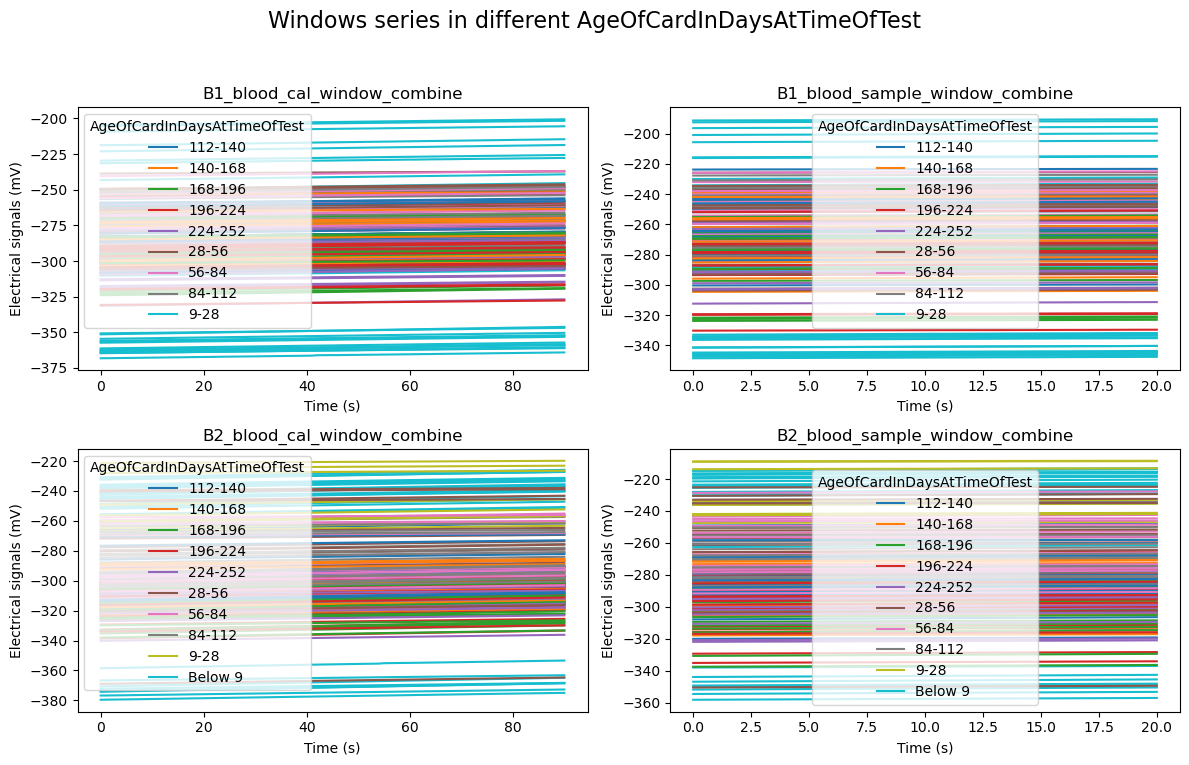

In [29]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(B1_blood_cal_window_combine, B1_blood_sample_window_combine, B2_blood_cal_window_combine, B2_blood_sample_window_combine, "AgeOfCardInDaysAtTimeOfTest", "B1_blood_cal_window_combine", "B1_blood_sample_window_combine", "B2_blood_cal_window_combine", "B2_blood_sample_window_combine")

#### System 1 and System 2: Sensor B - Aqueous - Cal and Sample Windows

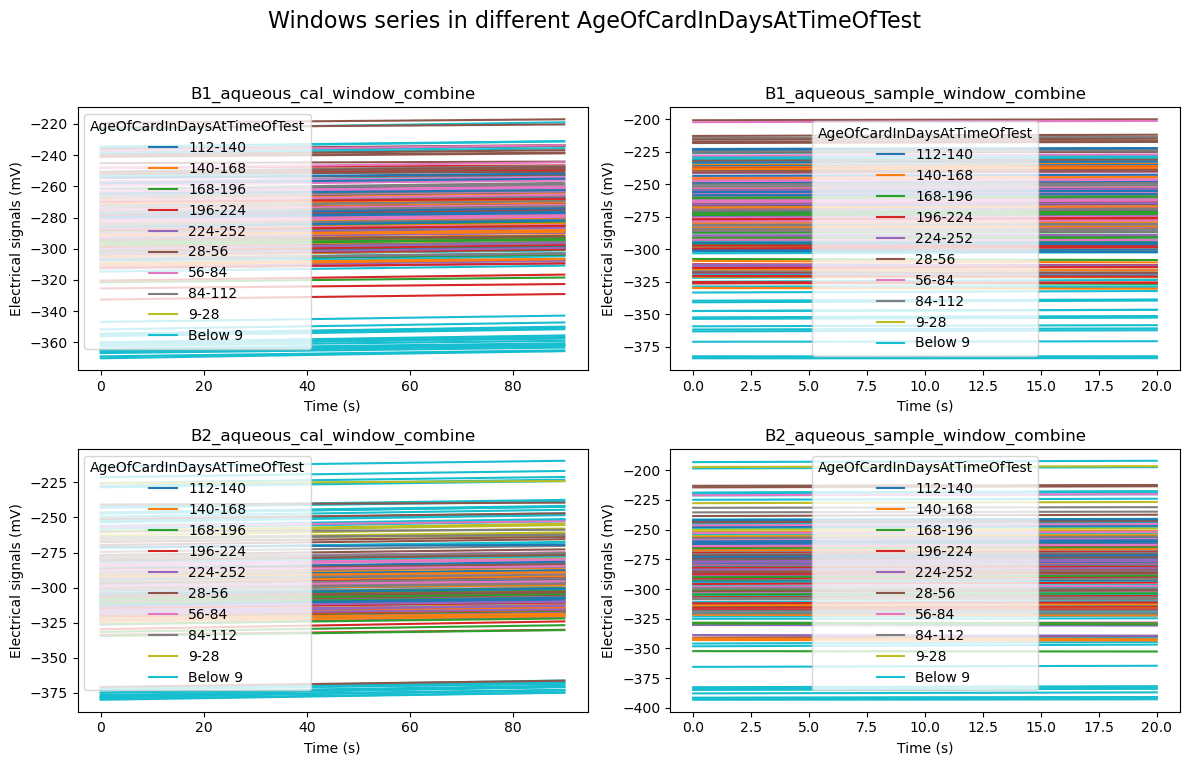

In [30]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(B1_aqueous_cal_window_combine, B1_aqueous_sample_window_combine, B2_aqueous_cal_window_combine, B2_aqueous_sample_window_combine, "AgeOfCardInDaysAtTimeOfTest", "B1_aqueous_cal_window_combine", "B1_aqueous_sample_window_combine", "B2_aqueous_cal_window_combine", "B2_aqueous_sample_window_combine")


### 7.2.3 Temperature

#### System 1 and System 2: Sensor A - Blood - Cal and Sample Windows

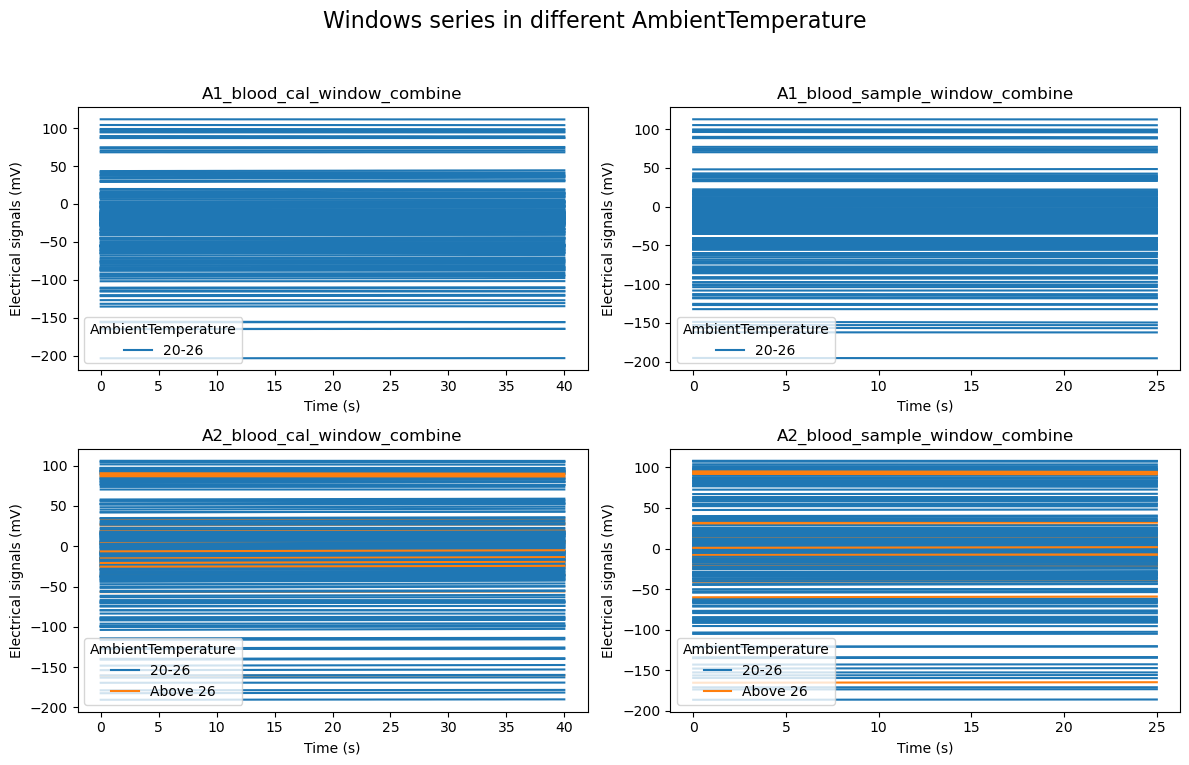

In [31]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(A1_blood_cal_window_combine, A1_blood_sample_window_combine,A2_blood_cal_window_combine, A2_blood_sample_window_combine,"AmbientTemperature","A1_blood_cal_window_combine", "A1_blood_sample_window_combine","A2_blood_cal_window_combine", "A2_blood_sample_window_combine")


#### System 1 and System 2: Sensor A - Aqueous - Cal and Sample Windows

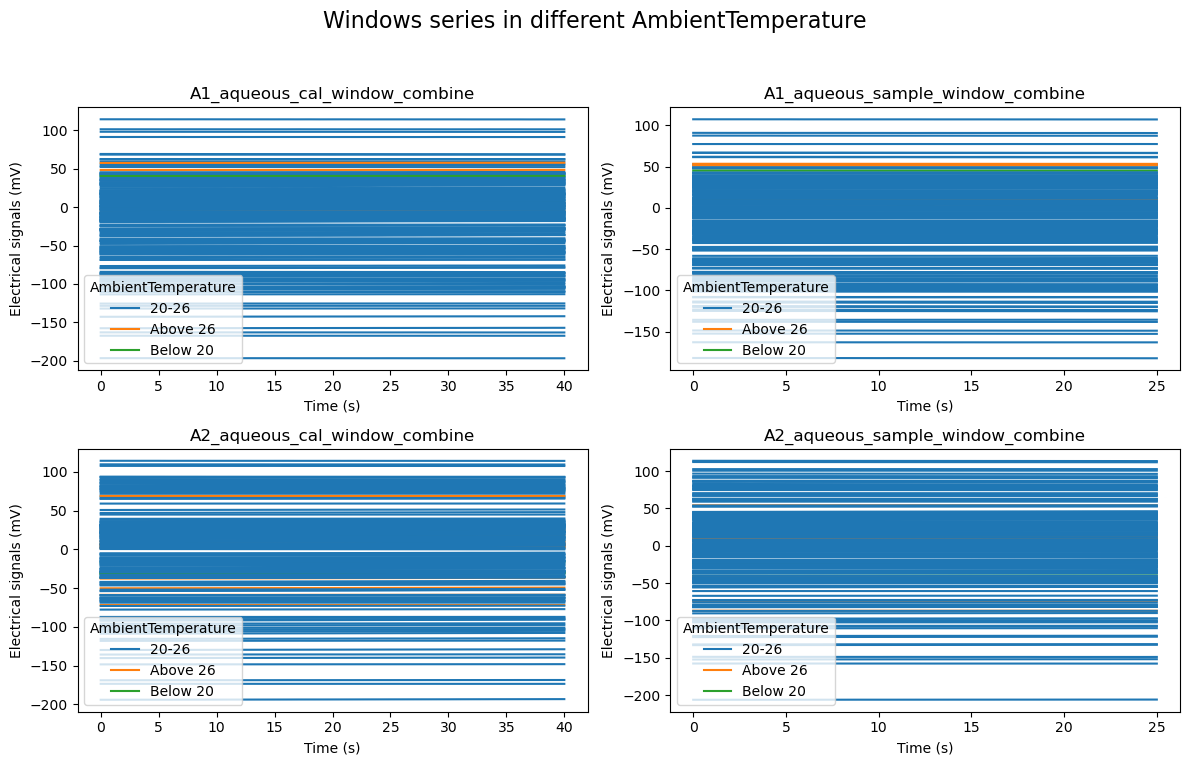

In [32]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(A1_aqueous_cal_window_combine, A1_aqueous_sample_window_combine,A2_aqueous_cal_window_combine, A2_aqueous_sample_window_combine,"AmbientTemperature","A1_aqueous_cal_window_combine", "A1_aqueous_sample_window_combine","A2_aqueous_cal_window_combine", "A2_aqueous_sample_window_combine")


#### System 1 and System 2: Sensor B - Blood - Cal and Sample Windows

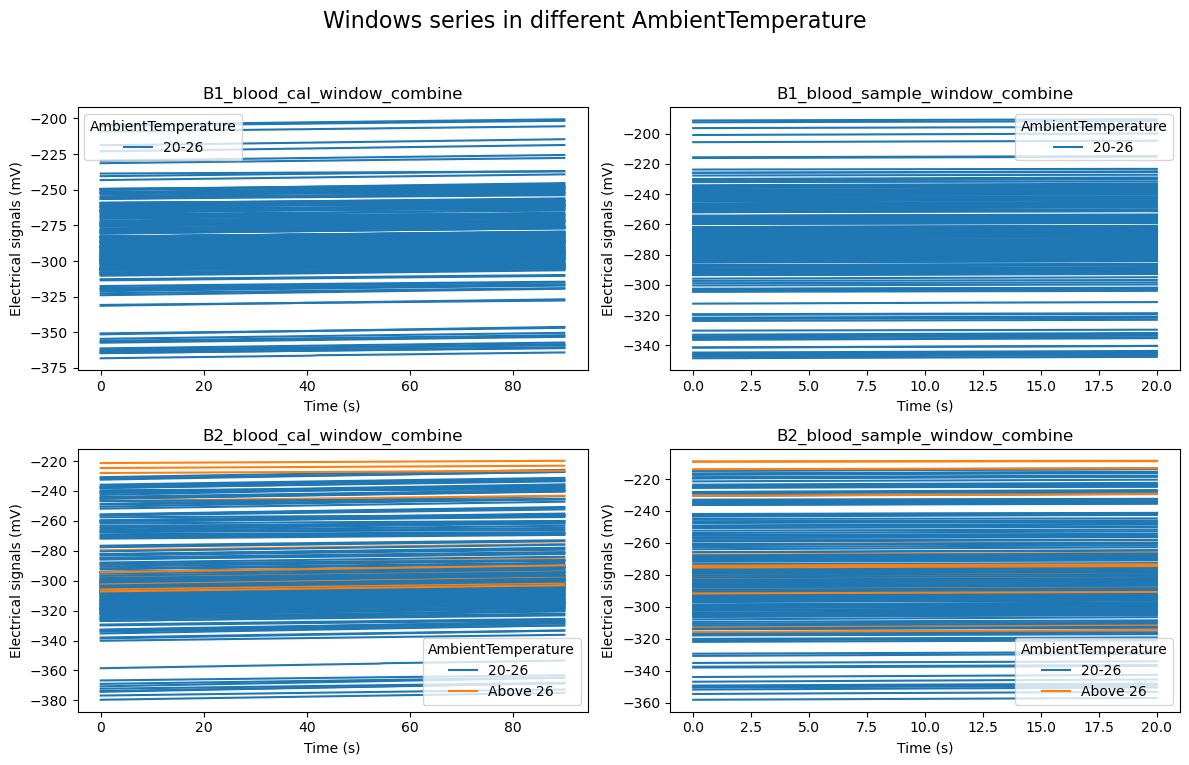

In [33]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(B1_blood_cal_window_combine, B1_blood_sample_window_combine, B2_blood_cal_window_combine, B2_blood_sample_window_combine, "AmbientTemperature", "B1_blood_cal_window_combine", "B1_blood_sample_window_combine", "B2_blood_cal_window_combine", "B2_blood_sample_window_combine")


#### System 1 and System 2: Sensor B - Aqueous - Cal and Sample Windows

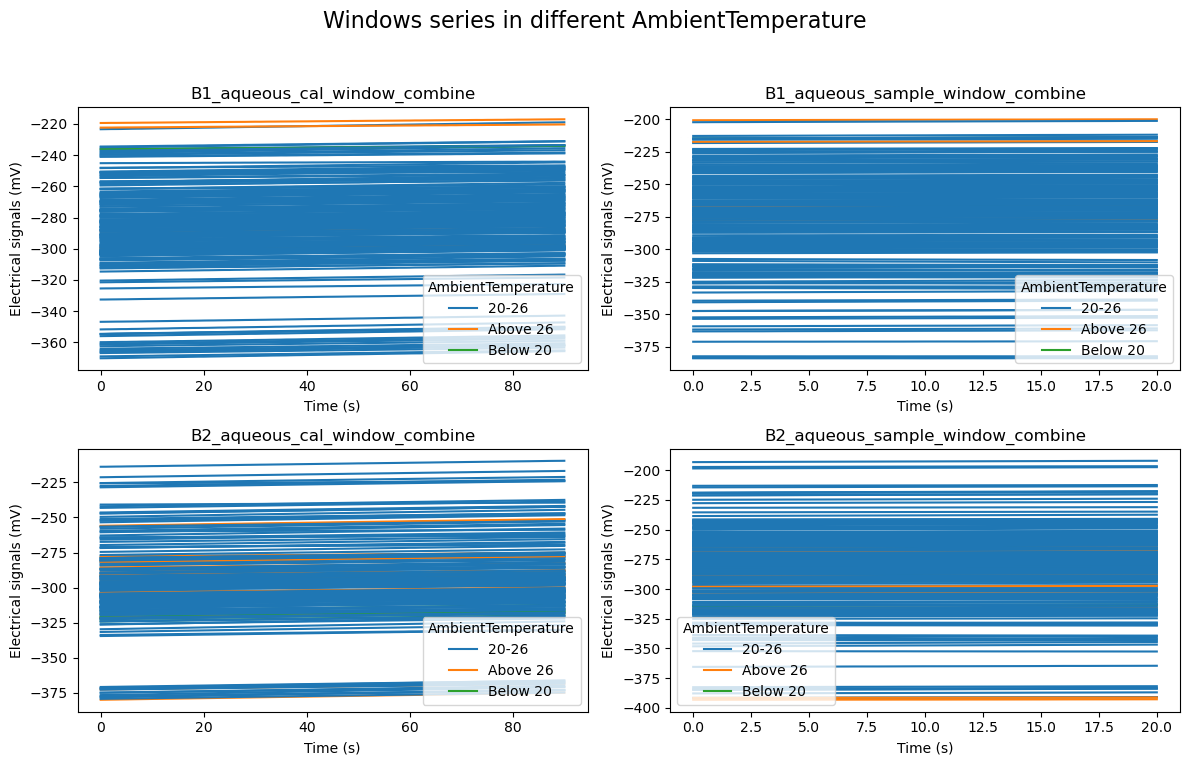

In [34]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(B1_aqueous_cal_window_combine, B1_aqueous_sample_window_combine, B2_aqueous_cal_window_combine, B2_aqueous_sample_window_combine, "AmbientTemperature", "B1_aqueous_cal_window_combine", "B1_aqueous_sample_window_combine", "B2_aqueous_cal_window_combine", "B2_aqueous_sample_window_combine")


# 8. Functional Principal Components

In [35]:
def perform_functional_pca(data_matrix, y_axis_min=None, y_axis_max=None, color_fpc1=None, color_fpc2=None):
    """
    Performs Functional Principal Component Analysis (FPCA) on a given data matrix and plots the results.

    Parameters:
    data_matrix (pd.DataFrame): A pandas DataFrame where each row represents a time series and each column represents a time point.
    y_axis_min (float, optional): The minimum value for the y-axis in the plots. Defaults to None.
    y_axis_max (float, optional): The maximum value for the y-axis in the plots. Defaults to None.
    color_fpc1 (str, optional): The color for the first functional principal component plot. Defaults to None.
    color_fpc2 (str, optional): The color for the second functional principal component plot. Defaults to None.

    Returns:
    None

    Prints:
    - The explained variance ratio of the first and second functional principal components.
    - The functional principal component scores for each time series.
    - The index and TestID of the time series contributing most to the first and second principal components.

    Plots:
    - The first and second functional principal components.
    - The individual plots of the first and second functional principal components.
    """
    fd = FDataGrid(data_matrix=data_matrix, grid_points=data_matrix.columns.astype(float))

    # Apply Functional PCA
    fpca = FPCA(n_components=2, centering=False)
    fpca.fit(fd)
    pc_scores = fpca.transform(fd)

    # Explain variance ratio
    print('Explain variance FPC1 (%): ', fpca.explained_variance_ratio_[0] * 100)
    print('Explain variance FPC2 (%): ', fpca.explained_variance_ratio_[1] * 100)

    # --- Loadings ---
    # Extract the principal components (loadings)
    principal_components = fpca.components_

    # Extract loadings for each time point from the first and second principal components
    loadings_pc1 = principal_components.data_matrix[0, :, 0]  # Loadings for the first PC
    loadings_pc2 = principal_components.data_matrix[1, :, 0]  # Loadings for the second PC
    loadings_df = pd.DataFrame({
    'PC1_Loadings': loadings_pc1,
    'PC2_Loadings': loadings_pc2}, index=[f'TimePoint_{i}' for i in range(data_matrix.shape[1])])
    #print("\nLoadings:\n", loadings_df)

    # --- Scores ---
    # Print the scores to see contributions of each time series to each principal component
    pc_scores_df = pd.DataFrame(pc_scores, columns=['PC1_Scores', 'PC2_Scores'],
                                index=[data_matrix.index[i] for i in range(data_matrix.shape[0])])
    print("FPC Scores:\n", pc_scores_df)

    # Identify which time series (functional data object) contributes the most to each principal component
    max_contribution_index_pc1 = np.argmax(np.abs(pc_scores[:, 0]))  # Index of the maximum absolute score in the first PC
    max_contribution_index_pc2 = np.argmax(np.abs(pc_scores[:, 1]))  # Index of the maximum absolute score in the second PC

    print(f'The time series contributing most to PC1 is at index {max_contribution_index_pc1} with TestID {data_matrix.index[max_contribution_index_pc1]}')
    print(f'The time series contributing most to PC2 is at index {max_contribution_index_pc2} with TestID {data_matrix.index[max_contribution_index_pc2]}')

    # --- Plotting Principal Components ---
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))

    # Both Functional PC's
    axs[0].plot(fpca.components_[0].grid_points[0], fpca.components_[0].data_matrix[0].flatten(), linestyle='-', label='FPC1', color = color_fpc1)
    axs[0].plot(fpca.components_[1].grid_points[0], fpca.components_[1].data_matrix[0].flatten(), linestyle='-', label='FPC2', color = color_fpc2)
   # axs[0].set_title("Functional Principal Components")
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Functional PC Values')
    axs[0].legend()
    axs[0].grid(False)
    axs[0].set_ylim(y_axis_min, y_axis_max)

    # FPC1
    axs[1].plot(fpca.components_[0].grid_points[0], fpca.components_[0].data_matrix[0].flatten(), linestyle='-', label='FPC1', color = color_fpc1)
    #axs[1].set_title("Functional Component 1")
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('')
    axs[1].legend()
    axs[1].grid(False)
    axs[1].set_ylim(y_axis_min, y_axis_max)

    # FPC2
    axs[2].plot(fpca.components_[1].grid_points[0], fpca.components_[1].data_matrix[0].flatten(), linestyle='-', label='FPC2', color = color_fpc2)
    #axs[2].set_title("Functional Component 2")
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('')
    axs[2].legend()
    axs[2].grid(False)
    axs[2].set_ylim(y_axis_min, y_axis_max)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()
    return fpca

In [36]:
# Note: For the following plots we can adjust the y-axis limit with the parameters y_axis_min and y_axis_max from the function perform_functional_pca().
# If these parameters are not provided then the plots will display the default range, however, we should be aware of this.
# For instance: perform_functional_pca(A1_blood_cal_window, y_axis_min=-0.6, y_axis_max=0.6)

----------------------------------------- Sensor A -----------------------------------------------

## Cal Window

### Cal Window: System 1/2 - Blood

In [37]:
# Running on center data is different than running on raw data
#perform_functional_pca(center_data(A1_blood_cal_window), color_fpc1='tab:blue', color_fpc2='tab:cyan')

Explain variance FPC1 (%):  99.99898060880852
Explain variance FPC2 (%):  0.0010154741982685061
FPC Scores:
           PC1_Scores  PC2_Scores
12414382 -462.318977    0.021936
12431655 -657.874641   -0.158044
12431672 -705.459190   -0.230144
12431673 -624.160789   -0.384360
12431675 -551.856043   -0.274452
...              ...         ...
12557509  256.190327    1.626748
12573906   72.254201    1.313238
12539051  499.807429   -0.026459
12623129  182.130371    1.075219
12470354  729.584352    0.413737

[210 rows x 2 columns]
The time series contributing most to PC1 is at index 161 with TestID 12573667
The time series contributing most to PC2 is at index 92 with TestID 12454406


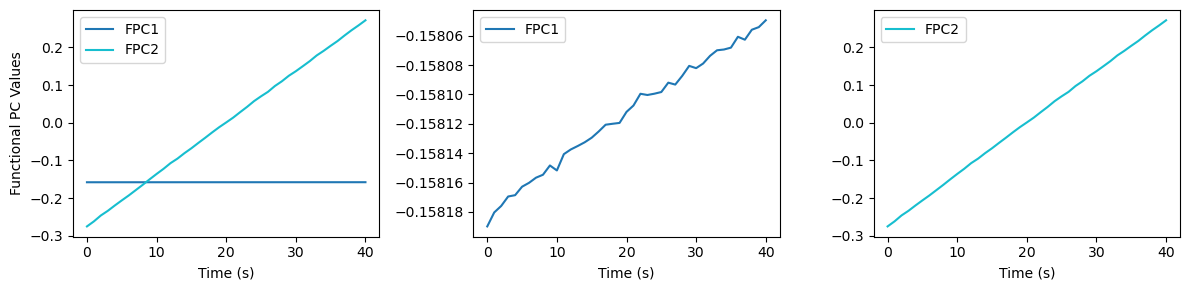

Explain variance FPC1 (%):  99.9991944620391
Explain variance FPC2 (%):  0.00080448100011433
FPC Scores:
          PC1_Scores  PC2_Scores
3545093 -480.485026   -0.342831
3545126 -504.415594   -0.369273
3545136 -523.775487   -0.164458
3545212 -509.217604   -0.362927
3545222 -588.150636   -0.635154
...             ...         ...
3518658 -570.910423    0.462688
3518659 -465.925702   -0.766972
3518660 -169.683668   -0.778673
3518691  -42.068819   -0.039341
3518675 -445.195433   -0.472431

[210 rows x 2 columns]
The time series contributing most to PC1 is at index 132 with TestID 3572427
The time series contributing most to PC2 is at index 93 with TestID 3547741


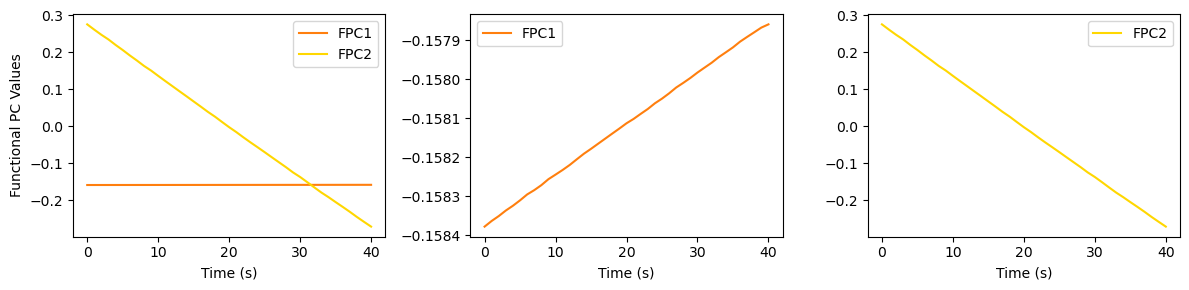

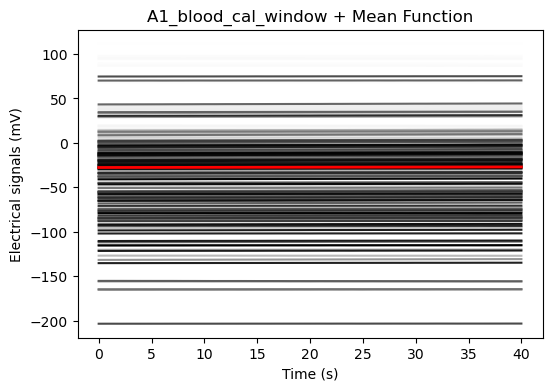

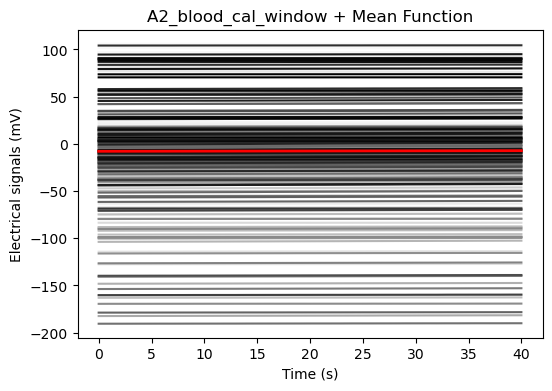

In [38]:
fpca_A1_blood_cal_window = perform_functional_pca(A1_blood_cal_window, color_fpc1='tab:blue', color_fpc2='tab:cyan')
fpca_A2_blood_cal_window = perform_functional_pca(A2_blood_cal_window, color_fpc1='tab:orange', color_fpc2='gold')
x_A1_blood_cal_window = fpca_A1_blood_cal_window.components_.grid_points
y_A1_blood_cal_window = fpca_A1_blood_cal_window.mean_.data_matrix
x_A2_blood_cal_window = fpca_A2_blood_cal_window.components_.grid_points
y_A2_blood_cal_window = fpca_A2_blood_cal_window.mean_.data_matrix

plot_all_time_series_and_mean_fpca(A1_blood_cal_window, 'A1_blood_cal_window + Mean Function', x_A1_blood_cal_window[0], y_A1_blood_cal_window.flatten())
plot_all_time_series_and_mean_fpca(A2_blood_cal_window, 'A2_blood_cal_window + Mean Function', x_A2_blood_cal_window[0], y_A2_blood_cal_window.flatten())

### Cal Window: System 1/2 - aqueous

Explain variance FPC1 (%):  99.99904252431632
Explain variance FPC2 (%):  0.0009541052218730671
FPC Scores:
           PC1_Scores  PC2_Scores
12414202 -374.881095   -0.113955
12414210 -431.501933    0.058511
12414251 -395.171955   -0.026434
12414261 -392.013525   -0.146490
12416098 -353.126027   -0.308897
...              ...         ...
12624887   58.709966   -2.248259
12624889   37.215439   -2.449293
12624890   93.585862   -1.292751
12479777  607.351321   -1.137716
12537664 -134.876455   -2.140253

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 188 with TestID 12572826
The time series contributing most to PC2 is at index 132 with TestID 12574472


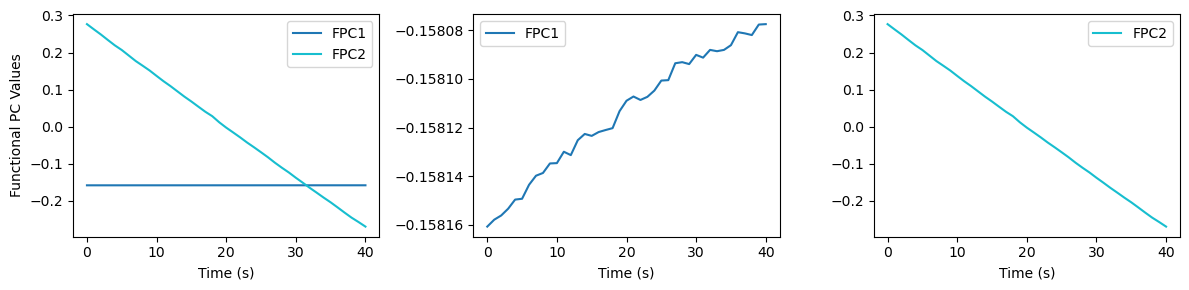

Explain variance FPC1 (%):  99.99893412558436
Explain variance FPC2 (%):  0.0010643207034913115
FPC Scores:
          PC1_Scores  PC2_Scores
3551305 -201.038673   -1.995968
3551322 -199.900074   -1.567892
3551024 -198.763044   -1.960539
3551040 -232.725595   -1.899557
3551361 -142.496912   -1.767979
...             ...         ...
3518396 -132.234065   -0.664526
3518410 -456.059609   -0.526211
3518425 -523.016600   -0.038792
3518428   -9.214450    0.174227
3518429   88.986178   -0.597824

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 176 with TestID 3568007
The time series contributing most to PC2 is at index 139 with TestID 3556000


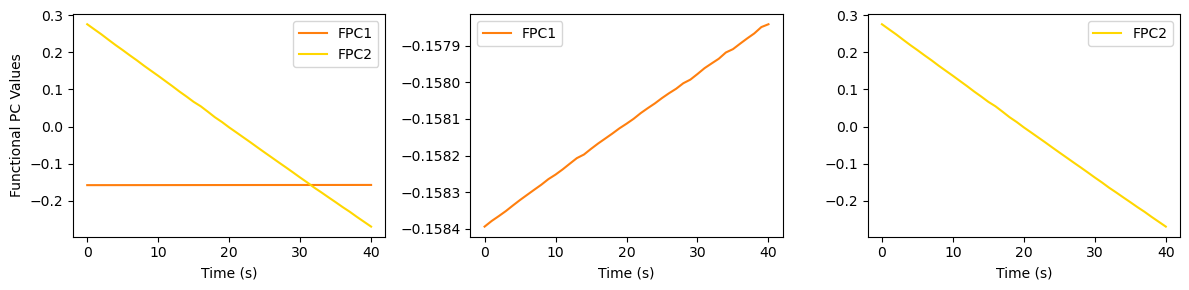

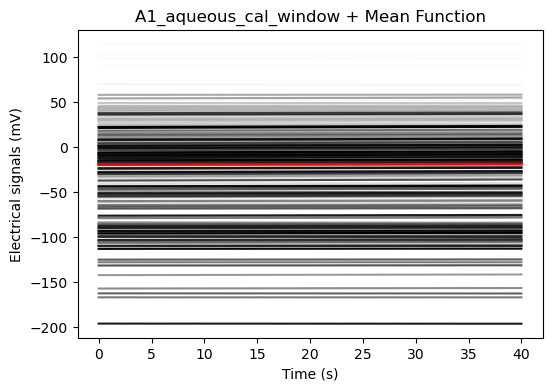

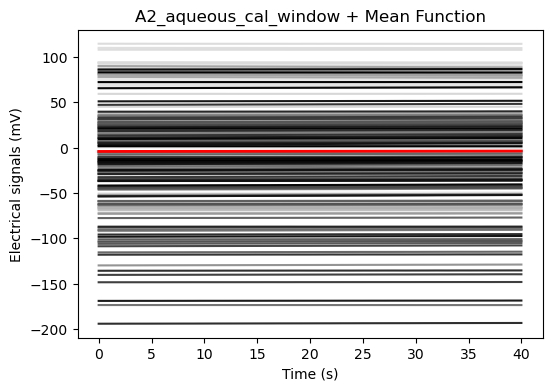

In [39]:
fpca_A1_aqueous_cal_window = perform_functional_pca(A1_aqueous_cal_window, color_fpc1='tab:blue', color_fpc2='tab:cyan')
fpca_A2_aqueous_cal_window = perform_functional_pca(A2_aqueous_cal_window, color_fpc1='tab:orange', color_fpc2='gold')
x_A1_aqueous_cal_window = fpca_A1_aqueous_cal_window.components_.grid_points
y_A1_aqueous_cal_window = fpca_A1_aqueous_cal_window.mean_.data_matrix
x_A2_aqueous_cal_window = fpca_A2_aqueous_cal_window.components_.grid_points
y_A2_aqueous_cal_window = fpca_A2_aqueous_cal_window.mean_.data_matrix

plot_all_time_series_and_mean_fpca(A1_aqueous_cal_window, 'A1_aqueous_cal_window + Mean Function', x_A1_aqueous_cal_window[0], y_A1_aqueous_cal_window.flatten())
plot_all_time_series_and_mean_fpca(A2_aqueous_cal_window, 'A2_aqueous_cal_window + Mean Function', x_A2_aqueous_cal_window[0], y_A2_aqueous_cal_window.flatten())

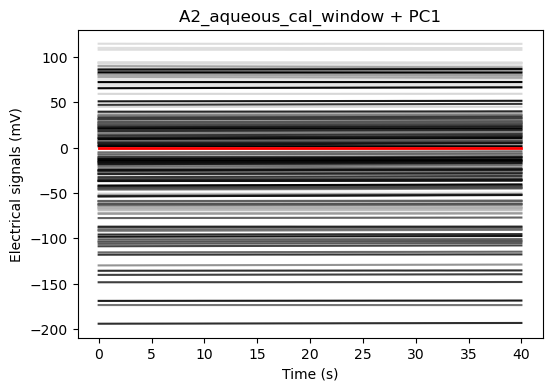

In [40]:
x_A2_aqueous_cal_window = fpca_A2_aqueous_cal_window.components_.grid_points
y_A2_aqueous_cal_window_pc1 = fpca_A2_aqueous_cal_window.components_[0].data_matrix
plot_all_time_series_and_mean_fpca(A2_aqueous_cal_window, 'A2_aqueous_cal_window + PC1', x_A2_aqueous_cal_window[0], y_A2_aqueous_cal_window_pc1.flatten())

## Sample Window

### Sample Window: System 1/2 - Blood

Explain variance FPC1 (%):  99.99959870095083
Explain variance FPC2 (%):  0.0003978287361460441
FPC Scores:
           PC1_Scores  PC2_Scores
12414382 -371.261622    0.345551
12431655 -525.163167    0.296042
12431672 -562.588031    0.297081
12431673 -497.130137    0.379552
12431675 -441.068171    0.311704
...              ...         ...
12557509  234.081098   -0.528080
12573906   15.609873    0.771889
12539051  386.908499    0.315385
12623129  122.837257   -0.314284
12470354  564.424543    0.072137

[210 rows x 2 columns]
The time series contributing most to PC1 is at index 161 with TestID 12573667
The time series contributing most to PC2 is at index 92 with TestID 12454406


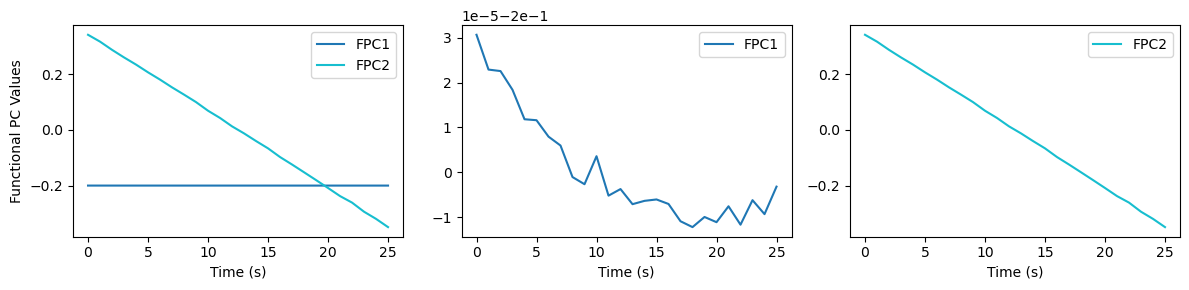

Explain variance FPC1 (%):  99.99965490453017
Explain variance FPC2 (%):  0.0003439284304083448
FPC Scores:
          PC1_Scores  PC2_Scores
3545093 -388.743802    0.086463
3545126 -408.214370    0.080591
3545136 -421.688166   -0.021687
3545212 -412.476496    0.074232
3545222 -476.787203    0.202409
...             ...         ...
3518658 -474.509193   -0.570052
3518659 -401.220395    0.218895
3518660 -170.721268   -0.000593
3518691  -41.633944   -0.031410
3518675 -363.433082    0.381245

[210 rows x 2 columns]
The time series contributing most to PC1 is at index 132 with TestID 3572427
The time series contributing most to PC2 is at index 49 with TestID 3569418


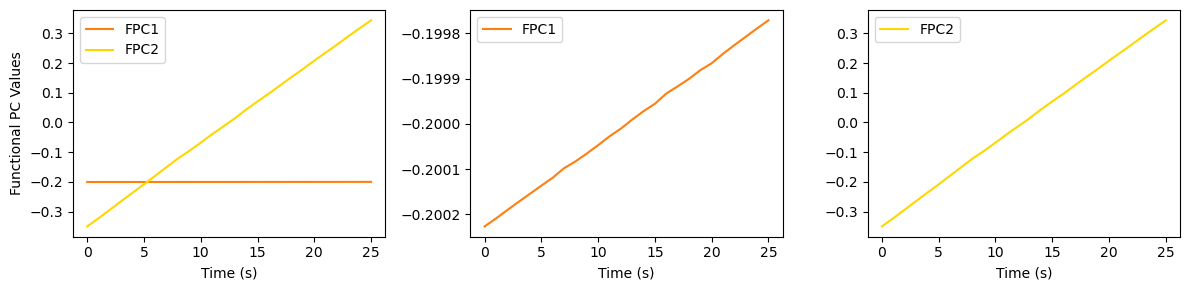

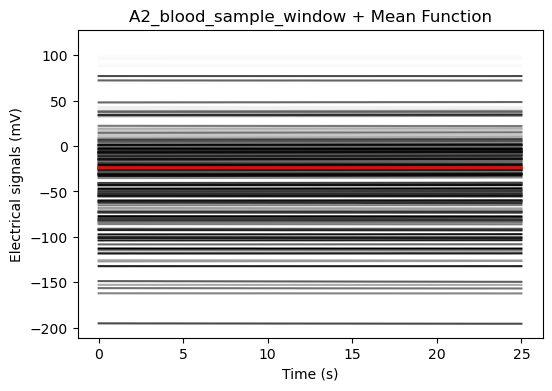

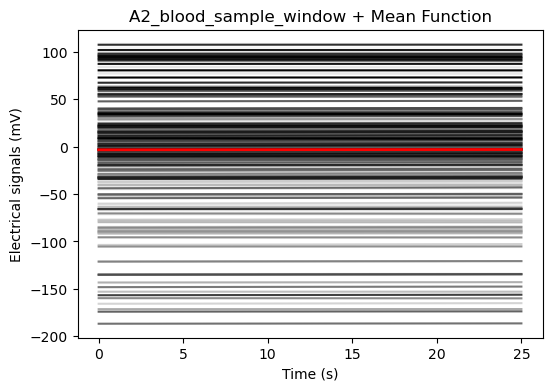

In [41]:
fpca_A1_blood_sample_window = perform_functional_pca(A1_blood_sample_window, color_fpc1='tab:blue', color_fpc2='tab:cyan')
fpca_A2_blood_sample_window = perform_functional_pca(A2_blood_sample_window, color_fpc1='tab:orange', color_fpc2='gold')
x_A1_blood_sample_window = fpca_A1_blood_sample_window.components_.grid_points
y_A1_blood_sample_window = fpca_A1_blood_sample_window.mean_.data_matrix
x_A2_blood_sample_window = fpca_A2_blood_sample_window.components_.grid_points
y_A2_blood_sample_window = fpca_A2_blood_sample_window.mean_.data_matrix

plot_all_time_series_and_mean_fpca(A1_blood_sample_window, 'A2_blood_sample_window + Mean Function', x_A1_blood_sample_window[0], y_A1_blood_sample_window.flatten())
plot_all_time_series_and_mean_fpca(A2_blood_sample_window, 'A2_blood_sample_window + Mean Function', x_A2_blood_sample_window[0], y_A2_blood_sample_window.flatten())

### Sample Window: System 1/2 - Aqueous

Explain variance FPC1 (%):  99.99976081361962
Explain variance FPC2 (%):  0.00023532487026643552
FPC Scores:
           PC1_Scores  PC2_Scores
12414202 -263.964123    0.221946
12414210 -308.315155    0.334964
12414251 -333.345500    0.559843
12414261 -331.708517    0.392551
12416098 -213.234989    0.020555
...              ...         ...
12624887   98.203683   -0.666861
12624889   83.898124   -0.643836
12624890  137.418479   -0.347478
12479777  446.198680   -0.342722
12537664 -190.892199   -0.144083

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 188 with TestID 12572826
The time series contributing most to PC2 is at index 42 with TestID 12634034


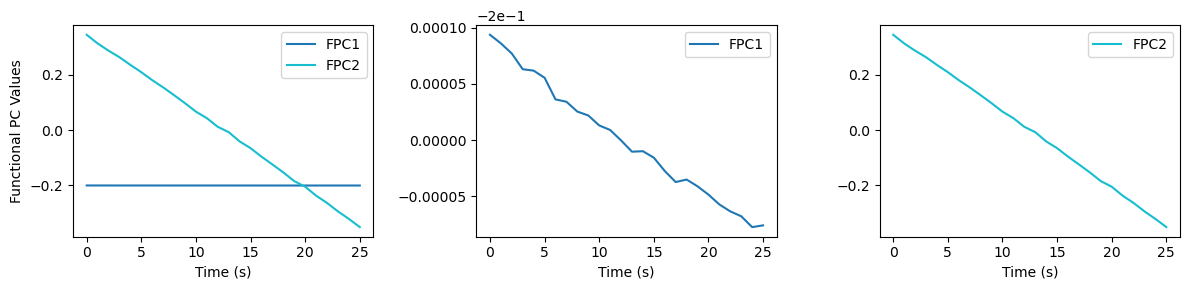

Explain variance FPC1 (%):  99.999672208388
Explain variance FPC2 (%):  0.0003258479413960844
FPC Scores:
          PC1_Scores  PC2_Scores
3551305 -136.910048   -0.682914
3551322 -133.725950   -0.574436
3551024 -196.668091   -0.852691
3551040 -222.367785   -0.755088
3551361  -89.614881   -0.682602
...             ...         ...
3518396 -182.998159   -0.175232
3518410 -436.275381   -0.189188
3518425 -482.971326    0.278315
3518428  -80.336256    0.069338
3518429   -9.559500   -0.403358

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 176 with TestID 3568007
The time series contributing most to PC2 is at index 139 with TestID 3556000


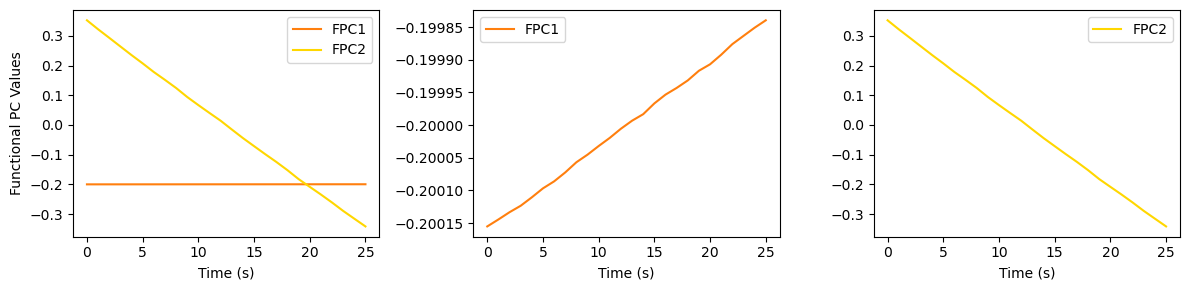

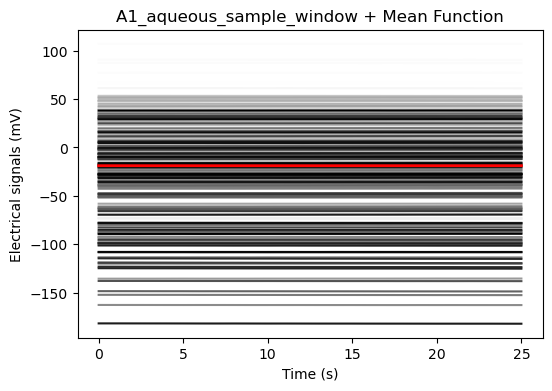

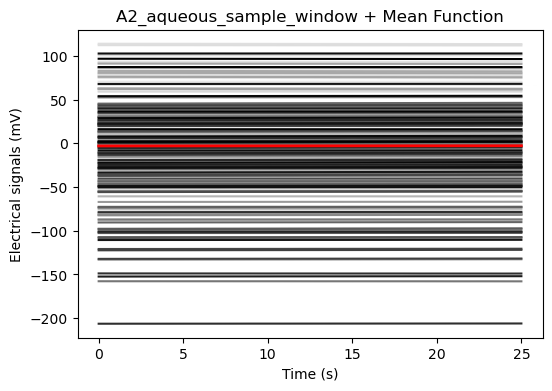

In [42]:
fpca_A1_aqueous_sample_window = perform_functional_pca(A1_aqueous_sample_window, color_fpc1='tab:blue', color_fpc2='tab:cyan')
fpca_A2_aqueous_sample_window = perform_functional_pca(A2_aqueous_sample_window, color_fpc1='tab:orange', color_fpc2='gold')
x_A1_aqueous_sample_window = fpca_A1_aqueous_sample_window.components_.grid_points
y_A1_aqueous_sample_window = fpca_A1_aqueous_sample_window.mean_.data_matrix
x_A2_aqueous_sample_window = fpca_A2_aqueous_sample_window.components_.grid_points
y_A2_aqueous_sample_window = fpca_A2_aqueous_sample_window.mean_.data_matrix

plot_all_time_series_and_mean_fpca(A1_aqueous_sample_window, 'A1_aqueous_sample_window + Mean Function', x_A1_aqueous_sample_window[0], y_A1_aqueous_sample_window.flatten())
plot_all_time_series_and_mean_fpca(A2_aqueous_sample_window, 'A2_aqueous_sample_window + Mean Function', x_A2_aqueous_sample_window[0], y_A2_aqueous_sample_window.flatten())

------------------------------------- Sensor B ------------------------------------------------

## Cal Window

### Cal Window:  System 1/2 - Blood

Explain variance FPC1 (%):  99.99357892490497
Explain variance FPC2 (%):  0.006390917757023785
FPC Scores:
            PC1_Scores  PC2_Scores
12414382 -2349.448661   -7.901750
12431655 -1929.736943   -5.705816
12431672 -1921.169430   -6.605797
12431673 -1966.759281   -5.998098
12431675 -2158.749895   -6.199916
...               ...         ...
12557509 -2823.910485   -4.956136
12573906 -2447.621876   -1.538109
12539051 -2689.120018   -2.004127
12623129 -2890.792913   -0.320346
12470354 -2850.791650    0.670119

[210 rows x 2 columns]
The time series contributing most to PC1 is at index 19 with TestID 12581664
The time series contributing most to PC2 is at index 103 with TestID 12437930


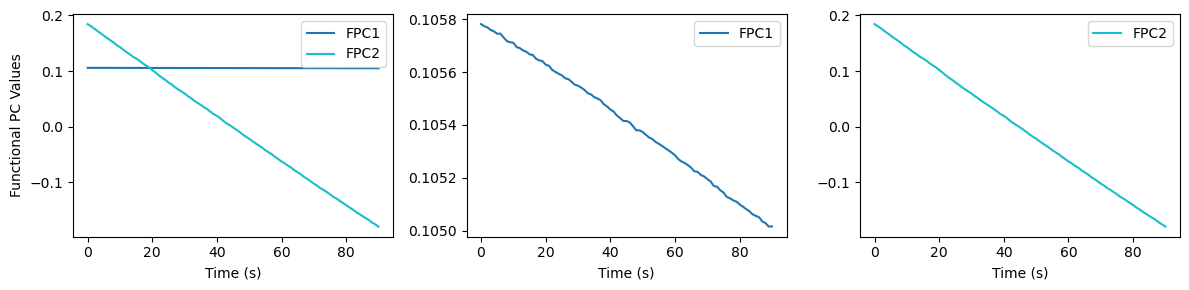

Explain variance FPC1 (%):  99.99195709910438
Explain variance FPC2 (%):  0.008024548745508777
FPC Scores:
           PC1_Scores  PC2_Scores
3545093  2333.751580   -9.073564
3545126  2405.520372   -7.763375
3545136  2352.145349   -8.939523
3545212  2366.793124   -7.685947
3545222  2234.151401   -8.735463
...              ...         ...
3518658  2123.996108    0.350586
3518659  2265.052497    0.712471
3518660  2475.037177    0.734588
3518691  2544.750522    1.695703
3518675  2272.563352    0.917396

[210 rows x 2 columns]
The time series contributing most to PC1 is at index 32 with TestID 3564418
The time series contributing most to PC2 is at index 6 with TestID 3545269


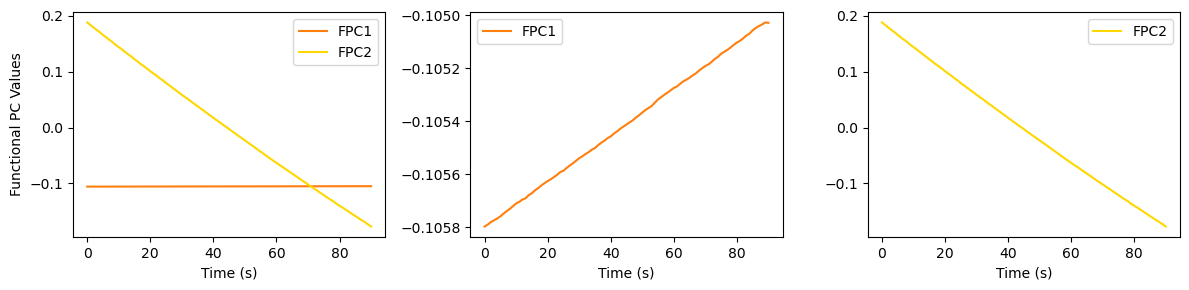

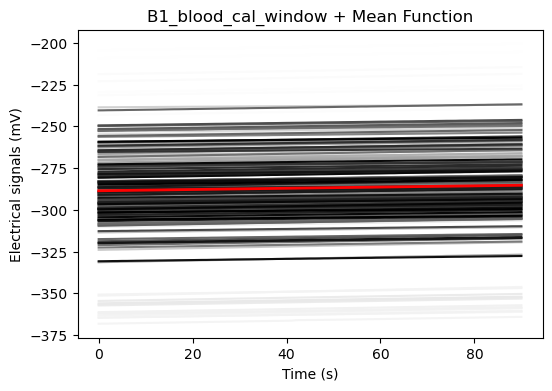

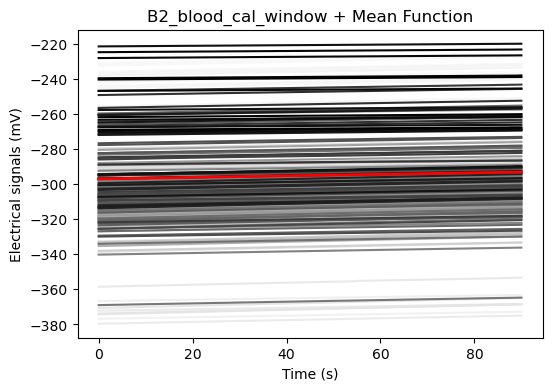

In [43]:
fpca_B1_blood_cal_window = perform_functional_pca(B1_blood_cal_window, color_fpc1='tab:blue', color_fpc2='tab:cyan')
fpca_B2_blood_cal_window = perform_functional_pca(B2_blood_cal_window, color_fpc1='tab:orange', color_fpc2='gold')
x_B1_blood_cal_window = fpca_B1_blood_cal_window.components_.grid_points
y_B1_blood_cal_window = fpca_B1_blood_cal_window.mean_.data_matrix
x_B2_blood_cal_window = fpca_B2_blood_cal_window.components_.grid_points
y_B2_blood_cal_window = fpca_B2_blood_cal_window.mean_.data_matrix

plot_all_time_series_and_mean_fpca(B1_blood_cal_window, 'B1_blood_cal_window + Mean Function', x_B1_blood_cal_window[0], y_B1_blood_cal_window.flatten())
plot_all_time_series_and_mean_fpca(B2_blood_cal_window, 'B2_blood_cal_window + Mean Function', x_B2_blood_cal_window[0], y_B2_blood_cal_window.flatten())

### Cal Window:  System 1/2 - Aqueous

Explain variance FPC1 (%):  99.99443363762875
Explain variance FPC2 (%):  0.005542758926634299
FPC Scores:
            PC1_Scores  PC2_Scores
12414202  2420.198744   -7.931698
12414210  2211.398769   -6.711641
12414251  2379.796872   -8.371384
12414261  2421.862758   -8.442186
12416098  2376.516836   -7.468663
...               ...         ...
12624887  2695.128149   -7.048502
12624889  2617.710782   -5.354731
12624890  2779.863684   -1.000415
12479777  3074.387497   -2.344609
12537664  2464.002576   -6.384574

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 21 with TestID 12544054
The time series contributing most to PC2 is at index 143 with TestID 12417705


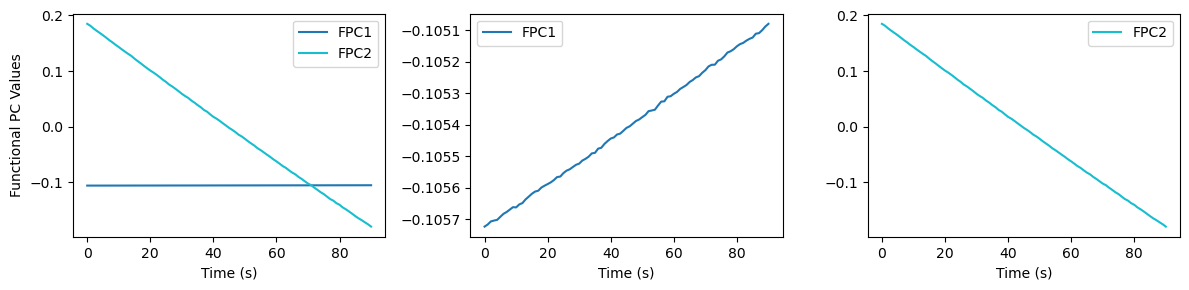

Explain variance FPC1 (%):  99.99323082099754
Explain variance FPC2 (%):  0.006750110469304989
FPC Scores:
           PC1_Scores  PC2_Scores
3551305 -2628.717556   -7.710840
3551322 -2727.328203   -7.871184
3551024 -2669.158109   -5.968937
3551040 -2658.580373   -7.686390
3551361 -2747.774044   -5.506896
...              ...         ...
3518396 -2460.947804   -0.446725
3518410 -2278.153085   -1.065619
3518425 -2133.344531   -1.855697
3518428 -2498.752496   -1.392127
3518429 -2563.918307   -1.078332

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 79 with TestID 3560167
The time series contributing most to PC2 is at index 99 with TestID 3552587


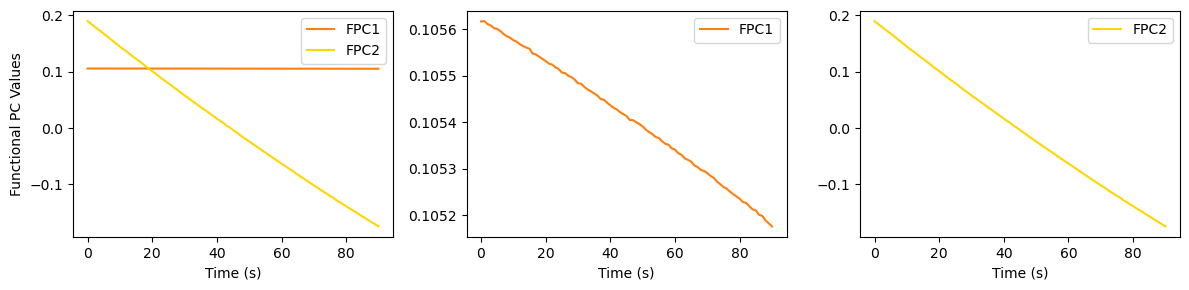

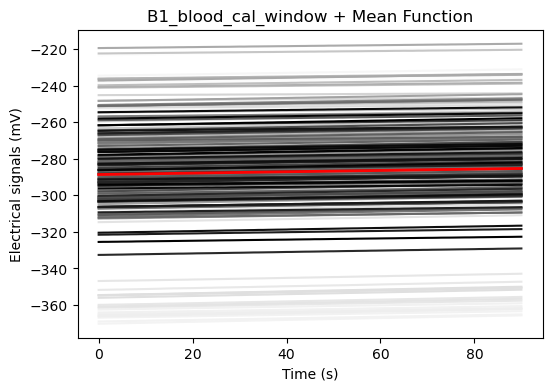

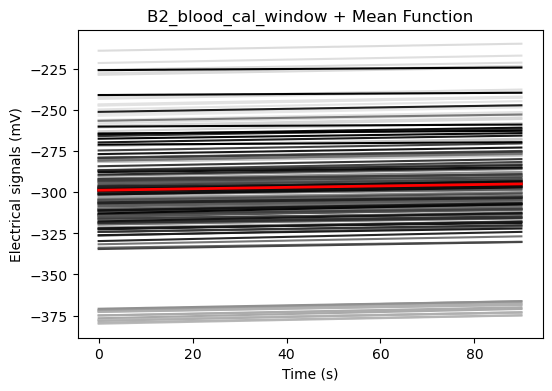

In [44]:
fpca_B1_aqueous_cal_window = perform_functional_pca(B1_aqueous_cal_window, color_fpc1='tab:blue', color_fpc2='tab:cyan')
fpca_B2_aqueous_cal_window= perform_functional_pca(B2_aqueous_cal_window, color_fpc1='tab:orange', color_fpc2='gold')
x_B1_aqueous_cal_window = fpca_B1_aqueous_cal_window.components_.grid_points
y_B1_aqueous_cal_window = fpca_B1_aqueous_cal_window.mean_.data_matrix
x_B2_aqueous_cal_window = fpca_B2_aqueous_cal_window.components_.grid_points
y_B2_aqueous_cal_window = fpca_B2_aqueous_cal_window.mean_.data_matrix

plot_all_time_series_and_mean_fpca(B1_aqueous_cal_window, 'B1_blood_cal_window + Mean Function', x_B1_aqueous_cal_window[0], y_B1_blood_cal_window.flatten())
plot_all_time_series_and_mean_fpca(B2_aqueous_cal_window, 'B2_blood_cal_window + Mean Function', x_B2_aqueous_cal_window[0], y_B2_aqueous_cal_window.flatten())

## Sample window

### Sample Window:  System 1/2 - Blood

Explain variance FPC1 (%):  99.99955714445844
Explain variance FPC2 (%):  0.0004335494495162668
FPC Scores:
            PC1_Scores  PC2_Scores
12414382 -1028.850848    0.676777
12431655  -858.869871    0.501548
12431672  -853.480436    0.532401
12431673  -876.028687    0.519053
12431675  -964.406328    0.601572
...               ...         ...
12557509 -1321.049642    0.402807
12573906  -999.406947   -0.020702
12539051 -1212.065482    0.330485
12623129 -1309.315741    0.221586
12470354 -1292.972681   -0.080014

[210 rows x 2 columns]
The time series contributing most to PC1 is at index 14 with TestID 12545034
The time series contributing most to PC2 is at index 20 with TestID 12601179


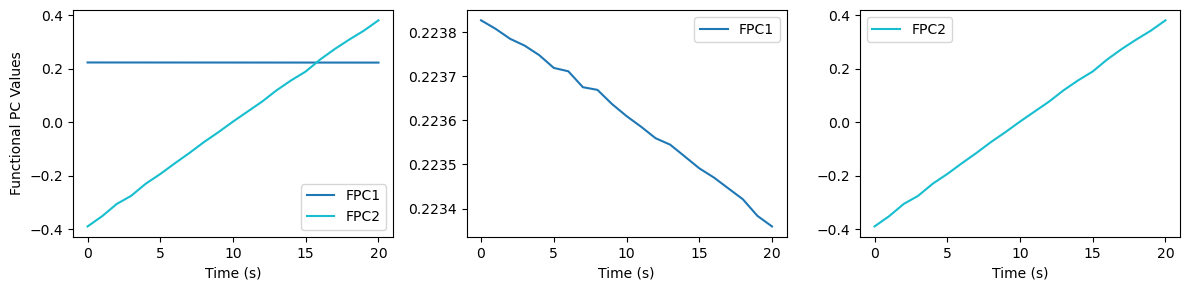

Explain variance FPC1 (%):  99.99959530524919
Explain variance FPC2 (%):  0.00040218626645384457
FPC Scores:
           PC1_Scores  PC2_Scores
3545093  1017.305706   -0.725728
3545126  1053.594354   -0.712576
3545136  1027.939722   -0.741475
3545212  1027.412245   -0.586239
3545222   966.389155   -0.723156
...              ...         ...
3518658   934.621273    0.201692
3518659  1006.343542    0.277136
3518660  1101.053386    0.313490
3518691  1165.679133    0.389215
3518675  1040.427610    0.113080

[210 rows x 2 columns]
The time series contributing most to PC1 is at index 25 with TestID 3559949
The time series contributing most to PC2 is at index 76 with TestID 3547717


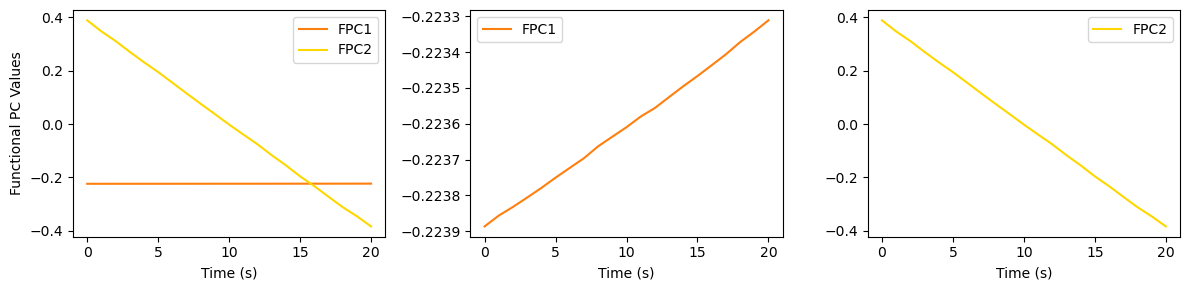

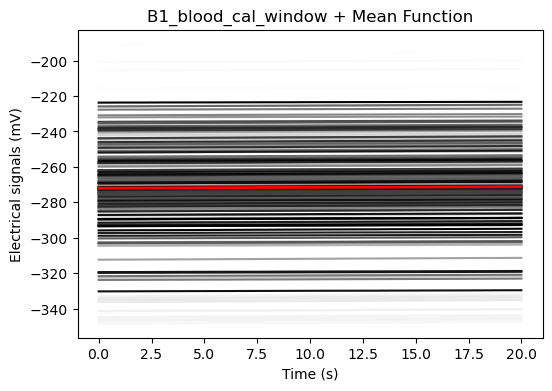

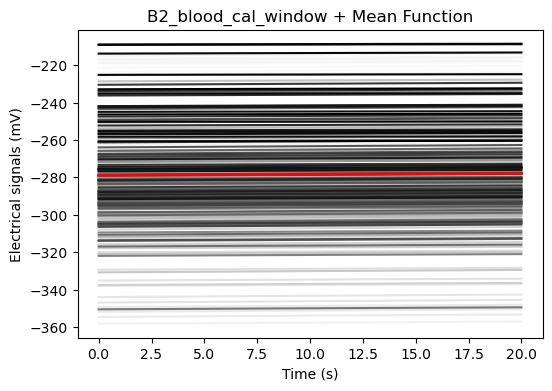

In [45]:
fpca_B1_blood_sample_window = perform_functional_pca(B1_blood_sample_window, color_fpc1='tab:blue', color_fpc2='tab:cyan')
fpca_B2_blood_sample_window = perform_functional_pca(B2_blood_sample_window, color_fpc1='tab:orange', color_fpc2='gold')
x_B1_blood_sample_window = fpca_B1_blood_sample_window.components_.grid_points
y_B1_blood_sample_window = fpca_B1_blood_sample_window.mean_.data_matrix
x_B2_blood_sample_window = fpca_B2_blood_sample_window.components_.grid_points
y_B2_blood_sample_window = fpca_B2_blood_sample_window.mean_.data_matrix

plot_all_time_series_and_mean_fpca(B1_blood_sample_window, 'B1_blood_cal_window + Mean Function', x_B1_blood_sample_window[0], y_B1_blood_sample_window.flatten())
plot_all_time_series_and_mean_fpca(B2_blood_sample_window, 'B2_blood_cal_window + Mean Function', x_B2_blood_sample_window[0], y_B2_blood_sample_window.flatten())

### Sample Window:  System 1/2 - Aqueous

Explain variance FPC1 (%):  99.99828812364301
Explain variance FPC2 (%):  0.0017043136035926314
FPC Scores:
            PC1_Scores  PC2_Scores
12414202  1116.150119   -3.343000
12414210  1022.340266   -3.059647
12414251  1008.061355   -3.338245
12414261  1026.168715   -3.494765
12416098  1190.603243   -2.989754
...               ...         ...
12624887  1343.337720   -2.982761
12624889  1319.306283   -2.622165
12624890  1421.871307   -2.045774
12479777  1336.502722   -3.923291
12537664  1003.649117   -3.177340

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 26 with TestID 12546583
The time series contributing most to PC2 is at index 21 with TestID 12544054


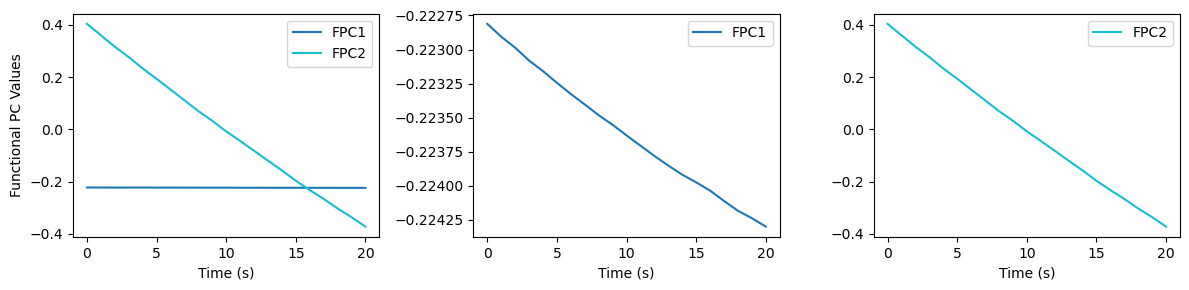

Explain variance FPC1 (%):  99.99902842573495
Explain variance FPC2 (%):  0.0009681293496233758
FPC Scores:
           PC1_Scores  PC2_Scores
3551305  1221.672448   -2.695909
3551322  1262.301640   -2.936713
3551024  1149.113190   -2.833913
3551040  1138.963837   -2.892751
3551361  1282.868294   -2.639725
...              ...         ...
3518396  1034.551659   -2.060912
3518410   951.418390   -2.122042
3518425   880.504066   -2.011902
3518428  1051.559285   -2.216693
3518429  1080.513121   -2.411153

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 79 with TestID 3560167
The time series contributing most to PC2 is at index 90 with TestID 3566835


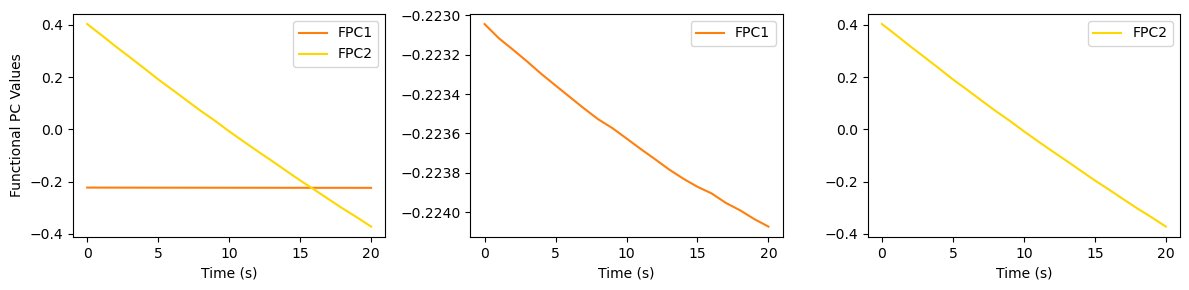

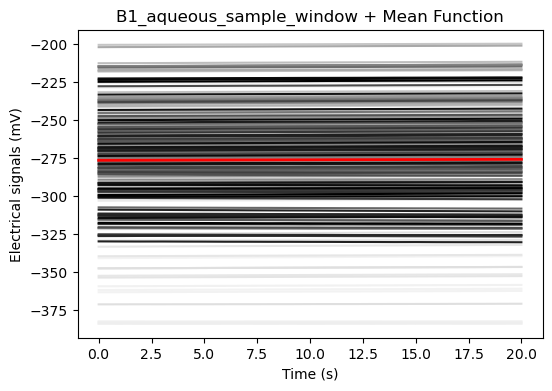

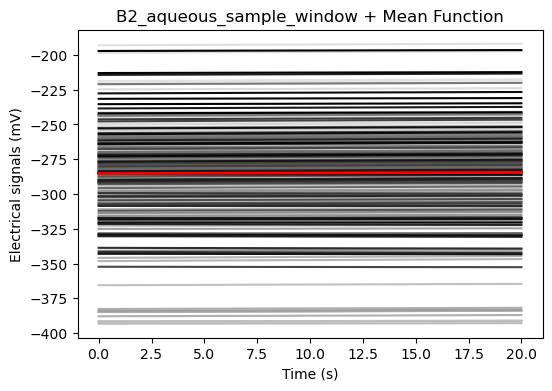

In [46]:
fpca_B1_aqueous_sample_window = perform_functional_pca(B1_aqueous_sample_window, color_fpc1='tab:blue', color_fpc2='tab:cyan')
fpca_B2_aqueous_sample_window = perform_functional_pca(B2_aqueous_sample_window, color_fpc1='tab:orange', color_fpc2='gold')

x_B1_aqueous_sample_window = fpca_B1_aqueous_sample_window.components_.grid_points
y_B1_aqueous_sample_window = fpca_B1_aqueous_sample_window.mean_.data_matrix
x_B2_aqueous_sample_window = fpca_B2_aqueous_sample_window.components_.grid_points
y_B2_aqueous_sample_window = fpca_B2_aqueous_sample_window.mean_.data_matrix

plot_all_time_series_and_mean_fpca(B1_aqueous_sample_window, 'B1_aqueous_sample_window + Mean Function', x_B1_aqueous_sample_window[0], y_B1_aqueous_sample_window.flatten())
plot_all_time_series_and_mean_fpca(B2_aqueous_sample_window,'B2_aqueous_sample_window + Mean Function', x_B2_aqueous_sample_window[0], y_B2_aqueous_sample_window.flatten())

# 8 FPCA

## 8.1. Functional PCA characterization function

In [47]:
def fpca_two_inputs(time_series_s1, time_series_s2, y_axis_min=None, y_axis_max=None):
    """
    Performs Functional Principal Component Analysis (FPCA) on two sets of time series data from different systems
    and plots the first principal component for both systems on the same graph.

    Parameters:
    time_series_s1 (pd.DataFrame): A pandas DataFrame representing time series data from System 1. Each row represents
                                   a time series and each column represents a time point.
    time_series_s2 (pd.DataFrame): A pandas DataFrame representing time series data from System 2. Each row represents
                                   a time series and each column represents a time point.
    y_axis_min (float, optional): The minimum value for the y-axis in the plot. Defaults to None.
    y_axis_max (float, optional): The maximum value for the y-axis in the plot. Defaults to None.

    Returns:
    tuple: A tuple containing two pandas DataFrames representing the functional principal component scores for System 1
           and System 2 respectively.

    Prints:
    - The explained variance ratio of the first principal component for both systems.
    - The functional principal component scores for each time series in both systems.
    - Plots the first principal component for both systems on the same graph.

    """
    # Convert the data matrix to an FDataGrid object
    fd_s1 = FDataGrid(data_matrix=time_series_s1, grid_points=time_series_s1.columns.astype(float)) # System 1
    fd_s2 = FDataGrid(data_matrix=time_series_s2, grid_points=time_series_s2.columns.astype(float)) # System 2

    # Apply Functional PCA for System 1
    fpca_s1 = FPCA(n_components=2, centering=True)
    fpca_s1.fit(fd_s1)
    fpc_and_scores_s1 = fpca_s1.transform(fd_s1)

    # Apply Functional PCA for System 2
    fpca_s2 = FPCA(n_components=2)
    fpca_s2.fit(fd_s2)
    fpc_and_scores_s2 = fpca_s2.transform(fd_s2)

    # --- Explain variance ratio ---
    # System 1
    print('S1 Explain variance FPC1 (%): ', fpca_s1.explained_variance_ratio_[0] * 100)
    #print('S1 Explain variance PC2 (%): ', fpca_s1.explained_variance_ratio_[1] * 100)
    # System 2
    print('S2 Explain variance FPC1 (%): ', fpca_s2.explained_variance_ratio_[0] * 100)
    #print('S2 Explain variance PC2 (%): ', fpca_s2.explained_variance_ratio_[1] * 100)

    # --- Loadings ---
    # Extract the principal components (loadings)
    principal_components_s1 = fpca_s1.components_ # System 1
    principal_components_s2 = fpca_s2.components_ # System 2

    # --- Scores ---
    # Print the scores to see contributions of each time series to each principal component

    # System 1
    pc_scores_s1 = pd.DataFrame(fpc_and_scores_s1, columns=['PC1_Scores', 'PC2_Scores'],
                                index=[time_series_s1.index[i] for i in range(time_series_s1.shape[0])])
    # System 2
    pc_scores_s2 = pd.DataFrame(fpc_and_scores_s2, columns=['PC1_Scores', 'PC2_Scores'],
                                index=[time_series_s2.index[i] for i in range(time_series_s2.shape[0])])

    # --- Plotting First Principal Component for both Systems ---
    # Extracting data for System 1
    x1 = fpca_s1.components_[0].grid_points[0]
    y1 = fpca_s1.components_[0].data_matrix[0].flatten()

    # Extracting data for System 2
    x2 = fpca_s2.components_[0].grid_points[0]
    y2 = fpca_s2.components_[0].data_matrix[0].flatten()

    # Plotting both curves in the same graph
    fig = plt.figure(figsize=(5, 3))
    plt.plot(x1, y1, linestyle='-', label='FPC1 - System 1')
    plt.plot(x2, y2, linestyle='-', label='FPC1 - System 2')

    plt.legend()
    plt.grid(False)
    plt.xlabel('Time (s)')
    plt.ylabel('Functional PC1 Values')
    #plt.title('System 1 versus System 2')
    plt.ylim(y_axis_min, y_axis_max)
    plt.show()

    return pc_scores_s1, pc_scores_s2,fpca_s1.components_[0],fpca_s2.components_[0]

In [48]:
def create_pc_scores_plots(pc_scores_s1, pc_scores_s2, features_s1, features_s2):
    """
    Creates scatterplots for the functional principal component scores mapping with colors the additional features for every TestID for two systems.

    Parameters:
    pc_scores_s1 (pd.DataFrame): A pandas DataFrame representing the functional principal component scores for System 1.
    pc_scores_s2 (pd.DataFrame): A pandas DataFrame representing the functional principal component scores for System 2.
    features_s1 (pd.DataFrame): A pandas DataFrame representing additional features for System 1.
    features_s2 (pd.DataFrame): A pandas DataFrame representing additional features for System 2.

    Returns:
    scatterplots: A concatenated chart containing scatterplots of the functional principal component scores combined with additional features for both systems.
    """
    # --- Scores combined with Additional Features ---
    # Reset the index, making the index a column in the DataFrame
    pc_scores_s1_reset = pc_scores_s1.reset_index()
    pc_scores_s2_reset = pc_scores_s2.reset_index()
    pc_scores_s1_reset.rename(columns={'index': 'TestID'}, inplace=True)
    pc_scores_s2_reset.rename(columns={'index': 'TestID'}, inplace=True)

    # Merging functional pc scores and additional features by TestID
    system1_scores_merged = pd.merge(pc_scores_s1_reset, features_s1, how='inner', on=['TestID'])
    system2_scores_merged = pd.merge(pc_scores_s2_reset, features_s2, how='inner', on=['TestID'])

    # --- Characterization of the Functional PC Scores ---

    # Select Features
    selected_columns = ['TestID', 'PC1_Scores','PC2_Scores','FluidType','AgeOfCardInDaysAtTimeOfTest', 'AmbientTemperature', 'Fluid_Temperature_Filled']
    data_s1 = system1_scores_merged[selected_columns].copy()
    data_s2 = system2_scores_merged[selected_columns].copy()

    # Binning continuous predictors into discrete intervals
    data_s1.loc[:, 'AmbientTempBin'] = pd.cut(data_s1['AmbientTemperature'],  bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26'])
    data_s2.loc[:, 'AmbientTempBin'] = pd.cut(data_s2['AmbientTemperature'],  bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26'])
    data_s1.loc[:, 'FluidTempBin'] = pd.cut(data_s1['Fluid_Temperature_Filled'],  bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26'])
    data_s2.loc[:, 'FluidTempBin'] = pd.cut(data_s2['Fluid_Temperature_Filled'],  bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26'])

    # CardAge by bins of 28 days
    # Determine the max age to set the range for bins
    max_age = data_s2['AgeOfCardInDaysAtTimeOfTest'].max()+1

    # Define the custom bins without duplicates
    bins_age = [0, 10, 28] + list(np.arange(56, max_age + 28, 28))

    # Create labels for the bins
    labels_age = ['[0-9]', '(9-28]'] + [f'({i}-{i+28}]' for i in np.arange(28, max_age, 28)]

    # Assign bins to the AgeBin column
    data_s1.loc[:, 'AgeBin'] = pd.cut(data_s1['AgeOfCardInDaysAtTimeOfTest'], bins=bins_age, labels=labels_age)
    data_s2.loc[:, 'AgeBin'] = pd.cut(data_s2['AgeOfCardInDaysAtTimeOfTest'], bins=bins_age, labels=labels_age)

    # --- Define a color map for fluid types ---
    color_map_temp = {
        'Below 20': '#4e79a7',
        '20-26': '#f28e2b',
        'Above 26': '#e16759',
    }

    # Combine data to get the overall min and max for both axes
    combined_data = pd.concat([data_s1, data_s2])

    # Determine the range for x and y axes
    min_x = combined_data['PC1_Scores'].min()
    max_x = combined_data['PC1_Scores'].max()
    min_y = combined_data['PC2_Scores'].min()
    max_y = combined_data['PC2_Scores'].max()

    # --- Visualizations ---
    # System 1
    scatter_age_s1 = alt.Chart(data_s1).mark_circle().encode(
    alt.X('PC1_Scores', title="Scores FPC1", scale=alt.Scale(domain=[min_x, max_x])),
    alt.Y('PC2_Scores', title="Scores FPC2", scale=alt.Scale(domain=[min_y, max_y])),
    color=alt.Color('AgeBin', scale=alt.Scale(scheme='tableau10'), title="Days"),
    tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('AgeOfCardInDaysAtTimeOfTest', title="Card Age")]
    ).properties(
        title='Card Age',
        width=580,
        height=280
   )


    scatter_temp_s1 = alt.Chart(data_s1).mark_circle().encode(
        alt.X('PC1_Scores', title="Scores FPC1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="Scores FPC2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('AmbientTempBin', scale=alt.Scale(domain=list(color_map_temp.keys()), range=list(color_map_temp.values())), title="°C"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('AmbientTemperature', title="Ambient Temperature")]
    ).properties(
        title='Ambient Temperature',
        width=580,
        height=280
    )


    scatter_fluid_s1 = alt.Chart(data_s1).mark_circle().encode(
        alt.X('PC1_Scores', title="Scores FPC1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="Scores FPC2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('FluidType', scale=alt.Scale(scheme='tableau10'), title="Fluid"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('FluidType', title="Fluid Type")]
    ).properties(
        title='Fluid Type',
        width=580,
        height=280
    )

    scatter_fluidTemp_s1 = alt.Chart(data_s1).mark_circle().encode(
        alt.X('PC1_Scores', title="Scores FPC1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="Scores FPC2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('FluidTempBin', scale=alt.Scale(domain=list(color_map_temp.keys()), range=list(color_map_temp.values())), title="°C"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('Fluid_Temperature_Filled', title="Fluid Temperature")]
    ).properties(
        title='Fluid Temperature',
        width=580,
        height=280
    )

    # System 2
    scatter_age_s2 = alt.Chart(data_s2).mark_circle().encode(
        alt.X('PC1_Scores', title="Scores FPC1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="Scores FPC2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('AgeBin', scale=alt.Scale(scheme='tableau10'), title="Days"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('AgeOfCardInDaysAtTimeOfTest', title="Card Age")]
    ).properties(
        title='Card Age',
        width=580,
        height=280
    )

    scatter_temp_s2 = alt.Chart(data_s2).mark_circle().encode(
        alt.X('PC1_Scores', title="Scores FPC1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="Scores FPC2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('AmbientTempBin', scale=alt.Scale(domain=list(color_map_temp.keys()), range=list(color_map_temp.values())), title="°C"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('AmbientTemperature', title="Ambient Temperature")]
    ).properties(
        title='Ambient Temperature',
        width=580,
        height=280
    )

    scatter_fluid_s2 = alt.Chart(data_s2).mark_circle().encode(
        alt.X('PC1_Scores', title="Scores FPC1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="Scores FPC2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('FluidType', scale=alt.Scale(scheme='tableau10'), title="Fluid"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('FluidType', title="Fluid Type")]
    ).properties(
        title='Fluid Type',
        width=580,
        height=280
    )

    scatter_fluidTemp_s2 = alt.Chart(data_s2).mark_circle().encode(
        alt.X('PC1_Scores', title="Scores FPC1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="Scores FPC2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('FluidTempBin', scale=alt.Scale(domain=list(color_map_temp.keys()), range=list(color_map_temp.values())), title="°C"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('Fluid_Temperature_Filled', title="Fluid Temperature")]
    ).properties(
        title='Fluid Temperature',
        width=580,
        height=280
    )


    # --- Display the plots ---
    # System 1 plots
    s1_plots = alt.hconcat(
        scatter_fluid_s1, scatter_age_s1, scatter_temp_s1, scatter_fluidTemp_s1
    ).resolve_scale(
        color='independent'
    ).properties(
        title='System 1'
    )

    # System 2 plots
    s2_plots = alt.hconcat(
        scatter_fluid_s2, scatter_age_s2, scatter_temp_s2, scatter_fluidTemp_s2
    ).resolve_scale(
        color='independent'
    ).properties(
        title='System 2'
    )

    # Concatenating plots in same grid
    plots_vconcatenated = alt.vconcat(
        s1_plots,
        s2_plots
    ).configure_view(
        stroke=None
    )

    return plots_vconcatenated

## 8.2 Functional PC1 plots (both systems) and Characterization of FPC Scores

### System 1 versus System 2: Sensor A - Blood - Cal Window

S1 Explain variance FPC1 (%):  99.99898060880852
S2 Explain variance FPC1 (%):  99.9991944620391


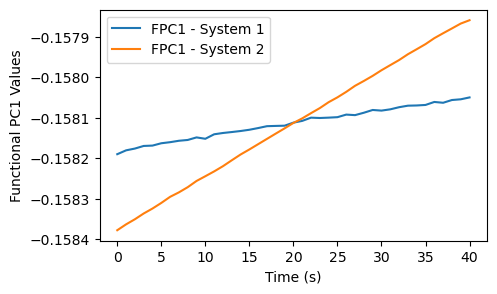

alt.VConcatChart(...)

In [49]:
pc_scores_s1_A_blood_cal_window, pc_scores_s2_A_blood_cal_window,fpca_s1_A_blood_cal_window,fpca_s2_A_blood_cal_window = fpca_two_inputs(A1_blood_cal_window, A2_blood_cal_window)
create_pc_scores_plots(pc_scores_s1_A_blood_cal_window, pc_scores_s2_A_blood_cal_window, A1_Merged, A2_Merged)

In [50]:
pc_scores_s2_A_blood_cal_window.to_csv('pc_scores_s2_A_blood_cal_window_rawData.csv', index=False)

### System 1 versus System 2: Sensor A - Aqueous - Cal Window

S1 Explain variance FPC1 (%):  99.99904252431632
S2 Explain variance FPC1 (%):  99.99893412558436


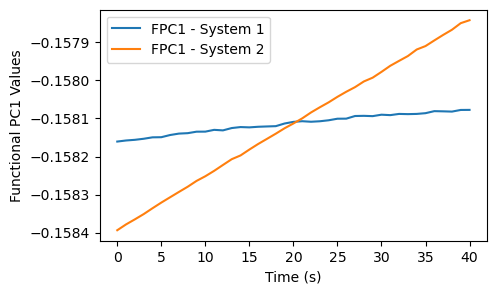

alt.VConcatChart(...)

In [51]:
pc_scores_s1_A_aqueous_cal_window, pc_scores_s2_A_aqueous_cal_window,fpca_s1_A_aqueous_cal_window,fpca_s2_A_aqueous_cal_window = fpca_two_inputs(A1_aqueous_cal_window, A2_aqueous_cal_window)
create_pc_scores_plots(pc_scores_s1_A_aqueous_cal_window, pc_scores_s2_A_aqueous_cal_window, A1_Merged, A2_Merged)

### System 1 versus System 2: Sensor A - Blood - Sample Window

S1 Explain variance FPC1 (%):  99.99959870095083
S2 Explain variance FPC1 (%):  99.99965490453017


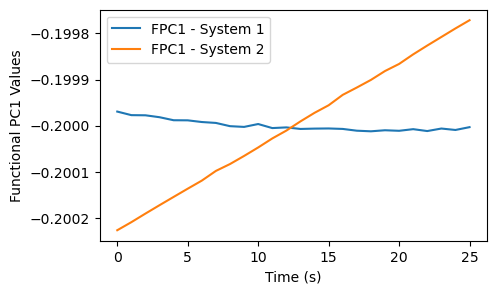

alt.VConcatChart(...)

In [52]:
pc_scores_s1_A_blood_sample_window, pc_scores_s2_A_blood_sample_window,fpca_s1_A_blood_sample_window,fpca_s2_A_blood_sample_window = fpca_two_inputs(A1_blood_sample_window, A2_blood_sample_window)
create_pc_scores_plots(pc_scores_s1_A_blood_sample_window, pc_scores_s2_A_blood_sample_window, A1_Merged, A2_Merged)

### System 1 versus System 2: Sensor A - Aqueous - Sample Window

S1 Explain variance FPC1 (%):  99.99976081361962
S2 Explain variance FPC1 (%):  99.999672208388


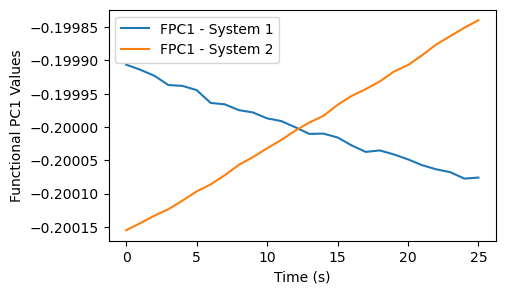

alt.VConcatChart(...)

In [53]:
pc_scores_s1_A_aqueous_sample_window, pc_scores_s2_A_aqueous_sample_window,fpca_s1_A_aqueous_sample_window,fpca_s2_A_aqueous_sample_window = fpca_two_inputs(A1_aqueous_sample_window, A2_aqueous_sample_window)
create_pc_scores_plots(pc_scores_s1_A_aqueous_sample_window, pc_scores_s2_A_aqueous_sample_window, A1_Merged, A2_Merged)

### System 1 versus System 2: Sensor B - Aqueous - Cal Window

S1 Explain variance FPC1 (%):  99.99443363762875
S2 Explain variance FPC1 (%):  99.99323082099754


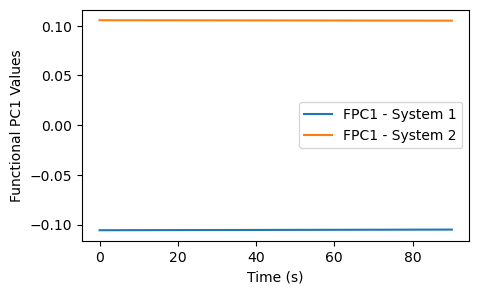

alt.VConcatChart(...)

In [54]:
pc_scores_s1_B_aqueous_cal_window, pc_scores_s2_B_aqueous_cal_window,fpca_s1_B_aqueous_cal_window,fpca_s2_B_aqueous_cal_window = fpca_two_inputs(B1_aqueous_cal_window, B2_aqueous_cal_window)
create_pc_scores_plots(pc_scores_s1_B_aqueous_cal_window, pc_scores_s2_B_aqueous_cal_window, B1_Merged, B2_Merged)

### System 1 versus System 2: Sensor B - Aqueous - Sample Window

S1 Explain variance FPC1 (%):  99.99828812364301
S2 Explain variance FPC1 (%):  99.99902842573495


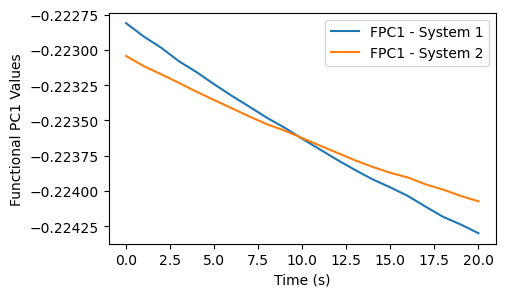

alt.VConcatChart(...)

In [55]:
pc_scores_s1_B_aqueous_sample_window, pc_scores_s2_B_aqueous_sample_window,fpca_s1_B_aqueous_sample_window,fpca_s2_B_aqueous_sample_window = fpca_two_inputs(B1_aqueous_sample_window, B2_aqueous_sample_window)
create_pc_scores_plots(pc_scores_s1_B_aqueous_sample_window, pc_scores_s2_B_aqueous_sample_window, B1_Merged, B2_Merged)

### System 1 versus System 2: Sensor B - Blood - Cal Window

S1 Explain variance FPC1 (%):  99.99357892490497
S2 Explain variance FPC1 (%):  99.99195709910438


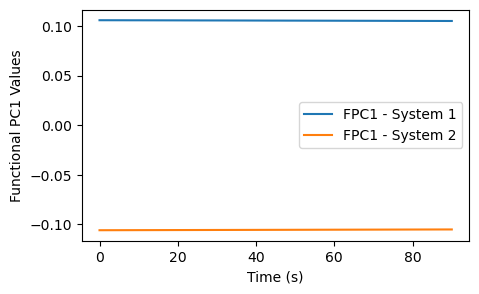

alt.VConcatChart(...)

In [56]:
pc_scores_s1_B_blood_cal_window, pc_scores_s2_B_blood_cal_window,fpca_s1_B_blood_cal_window,fpca_s2_B_blood_cal_window = fpca_two_inputs(B1_blood_cal_window, B2_blood_cal_window)
create_pc_scores_plots(pc_scores_s1_B_blood_cal_window, pc_scores_s2_B_blood_cal_window, B1_Merged, B2_Merged)

### System 1 versus System 2: Sensor B - Blood - Sample Window

S1 Explain variance FPC1 (%):  99.99955714445844
S2 Explain variance FPC1 (%):  99.99959530524919


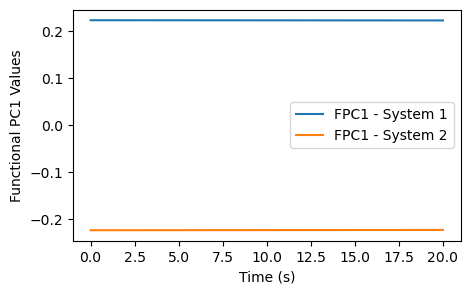

alt.VConcatChart(...)

In [57]:
pc_scores_s1_B_blood_sample_window, pc_scores_s2_B_blood_sample_window,fpca_s1_B_blood_sample_window,fpca_s2_B_blood_sample_window = fpca_two_inputs(B1_blood_sample_window, B2_blood_sample_window)
create_pc_scores_plots(pc_scores_s1_B_blood_sample_window, pc_scores_s2_B_blood_sample_window, B1_Merged, B2_Merged)

## 8.3 Linear Regression

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     6220.
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           2.25e-25
Time:                        17:58:08   Log-Likelihood:                 217.26
No. Observations:                  21   AIC:                            -430.5
Df Residuals:                      19   BIC:                            -428.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2238   3.44e-06    6.5e+04      0.0

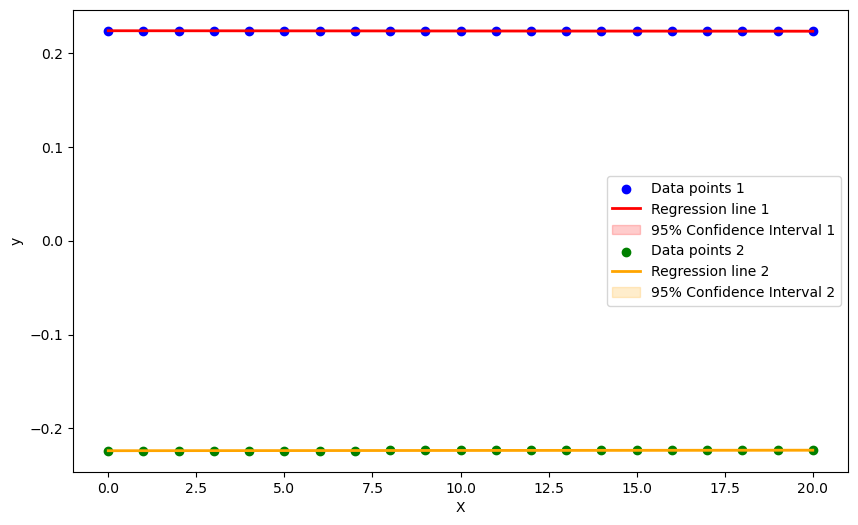

In [58]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assume you already have data for x1, y1, x2, and y2
x1 = fpca_s1_B_blood_sample_window.grid_points[0]
y1 = fpca_s1_B_blood_sample_window.data_matrix[0].flatten()
x2 = fpca_s2_B_blood_sample_window.grid_points[0]
y2 = fpca_s2_B_blood_sample_window.data_matrix[0].flatten()

# Add a constant to the feature variables
x1_with_const = sm.add_constant(x1)
x2_with_const = sm.add_constant(x2)

# Create and fit a linear regression model for x1 and y1
model1 = sm.OLS(y1, x1_with_const).fit()

# Create and fit a linear regression model for x2 and y2
model2 = sm.OLS(y2, x2_with_const).fit()

# Output detailed summary of the models
summary1 = model1.summary()
summary2 = model2.summary()
print(summary1)
print(summary2)

# Extract predicted values from the models
y1_pred = model1.predict(x1_with_const)
y2_pred = model2.predict(x2_with_const)

# Compute confidence intervals
pred1 = model1.get_prediction(x1_with_const)
pred_summary1 = pred1.summary_frame(alpha=0.05)  # 95% confidence interval
ci_lower1 = pred_summary1['obs_ci_lower']
ci_upper1 = pred_summary1['obs_ci_upper']

pred2 = model2.get_prediction(x2_with_const)
pred_summary2 = pred2.summary_frame(alpha=0.05)  # 95% confidence interval
ci_lower2 = pred_summary2['obs_ci_lower']
ci_upper2 = pred_summary2['obs_ci_upper']

# Visualize the results
plt.figure(figsize=(10, 6))

# Plot results for the first set of data
plt.scatter(x1, y1, color='blue', label='Data points 1')
plt.plot(x1, y1_pred, color='red', linewidth=2, label='Regression line 1')
plt.fill_between(x1, ci_lower1, ci_upper1, color='red', alpha=0.2, label='95% Confidence Interval 1')

# Plot results for the second set of data
plt.scatter(x2, y2, color='green', label='Data points 2')
plt.plot(x2, y2_pred, color='orange', linewidth=2, label='Regression line 2')
plt.fill_between(x2, ci_lower2, ci_upper2, color='orange', alpha=0.2, label='95% Confidence Interval 2')

plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


# 9. Functional Regression

## Define useful function

In [59]:
def Function_regression(windows, Merge_dataset, len_time=40, predictor=["AmbientTemperature", "AgeOfCardInDaysAtTimeOfTest"]):
    """
    Perform functional regression using the given data.

    Parameters:
    windows (DataFrame): The dataset containing the time series data.
    Merge_dataset (DataFrame): The dataset containing the predictors.
    len_time (int): The number of basis functions to use for the Fourier basis. Default is 40.
    predictor (list): The list of predictor variables to use in the regression. Default includes 'AmbientTemperature' and 'AgeOfCardInDaysAtTimeOfTest'.

    Returns:
    funct_reg (LinearRegression): The fitted linear regression model.
    """

    # Prepare Data
    # Transform the time series data into a list
    merged_column = [list(row) for row in windows.iloc[:, :].to_numpy()]

    # Convert the list to functional data object with Fourier basis
    Y = FDataGrid(merged_column, grid_points=range(len(merged_column[1])))
    basis = FourierBasis(n_basis=len_time)
    y = Y.coordinates[0].to_basis(basis)

    # Prepare the predictor data
    x = Merge_dataset.loc[:, predictor]

    # Fit the linear regression model
    funct_reg = LinearRegression(fit_intercept=True)
    funct_reg.fit(x, y)

    # Print model summary
    print("To check if we need to move any time stamp", "\n")
    intercept = funct_reg.intercept_
    print("The intercept of this model is:", intercept, "\n")
    for i in range(len(predictor)):
        coef = funct_reg.coef_[i]
        print("The coefficient of {} of this model is: {}".format(predictor[i], coef), "\n")

    return funct_reg


In [60]:
def coefficent_visualization(funct_reg, funct_reg2, predictor, interval, title):
    """
    Visualize the coefficients of two functional regression models over a specified interval.

    Parameters:
    funct_reg (LinearRegression): The first fitted linear regression model.
    funct_reg2 (LinearRegression): The second fitted linear regression model.
    predictor (list): The list of predictor variables.
    interval (slice): The slice object representing the interval of interest for the coefficients.
    title (str): The title for the overall plot.

    Returns:
    None: This function displays the plots of the coefficients.
    """
    num_predictors = len(predictor)
    num_intervals = len(funct_reg.intercept_.coefficients[0][interval])

    fig, axs = plt.subplots(num_predictors + 1, 1, figsize=(8, 6*num_predictors))

    # Set the overall title for the figure
    fig.suptitle(title, fontsize=16)

    # Plot the intercepts for both systems
    axs[0].plot(np.arange(num_intervals), funct_reg.intercept_.coefficients[0][interval], label='Intercept in system 1')
    axs[0].plot(np.arange(num_intervals), funct_reg2.intercept_.coefficients[0][interval], label='Intercept in system 2')
    axs[0].legend()
    axs[0].set_title('Intercept')

    # Plot the coefficients for each predictor
    for i in range(num_predictors):
        axs[i + 1].plot(np.arange(num_intervals), funct_reg.coef_[i].coefficients[0][interval], label='Coefficient in system 1')
        axs[i + 1].plot(np.arange(num_intervals), funct_reg2.coef_[i].coefficients[0][interval], label='Coefficient in system 2')
        axs[i + 1].legend()
        axs[i + 1].set_title(predictor[i])

    # Adjust the layout to make room for the title
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## Regression result

This is the coeffcient from the output of the model.
Because of the different magnitude, we need to choose which time stamps will we visualize

### Cal window

#### Sensor A

##### General

In [61]:
print("System 1:")
A1_cal_window_funct_reg = Function_regression(A1_cal_window,A1_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_cal_window_funct_reg = Function_regression(A2_cal_window,A2_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


System 1:
To check if we need to move any time stamp 

The intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 40.0),), n_basis=41, period=40.0),
    coefficients=[[ 5.66084940e+02 -3.40252064e+01  8.82549945e+00 -2.00662195e+00
       1.54360484e+01 -9.16580385e+00 -1.31187149e+01 -1.66868858e+01
      -1.26003005e+01  1.36805152e+01 -1.97336462e+01  3.33110221e+01
       6.90947007e+00  1.77335361e+00  2.03501515e+00 -7.95541919e+00
       1.50617621e+01 -1.31188099e+01  5.78833887e+00 -1.47379558e+01
       1.06993243e+01 -3.13814858e+01  1.75595615e+01 -3.14904603e+01
      -7.31933387e+00 -1.09911431e+01 -3.66689688e+00 -2.76792733e+01
       8.27349450e+00  5.73793405e+00 -1.06424902e+01 -5.17577233e+00
       1.16090463e+01  3.61879648e+01 -2.43102416e+01  2.62136648e+01
      -1.67139164e+01  8.80944587e+00  2.34797550e+01 -6.54778130e+14
      -1.58427221e+00]]) 

The coefficient of AmbientTemperature of this model is: FDataBasis(
    _basis=Fou

##### Blood

In [62]:
print("System 1:")
A1_blood_cal_window_funct_reg = Function_regression(A1_blood_cal_window,A1_blood_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_blood_cal_window_funct_reg = Function_regression(A2_blood_cal_window,A2_blood_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


System 1:
To check if we need to move any time stamp 

The intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 40.0),), n_basis=41, period=40.0),
    coefficients=[[ 1.30887471e+03  2.53612781e+01  4.49386094e+01 -1.30409946e+02
       2.05646713e+01 -4.80155025e+01  5.77801737e+01  6.17961562e+01
       8.71409064e+01  5.55178424e+01 -3.87831431e+01  1.56958806e+02
       3.52011871e+01 -1.06383914e+02  1.56920998e+02 -1.44944934e+02
       5.74102748e+01 -2.40224264e+01 -7.05340941e+01 -2.87465686e+02
      -2.90895969e+01  5.66928677e+01 -7.42140571e+01  1.02096242e+01
      -1.86039975e+02  6.05135258e+01  7.38292715e+01 -2.49003292e+01
      -6.56218122e+01  1.30735444e+02  1.64061834e+02 -7.03291375e+01
      -3.06710990e+02 -2.17173630e+02 -9.29222895e+01 -3.80028762e+01
      -4.37188249e+01 -1.38165359e+02 -2.01639098e+02 -1.84776366e+15
       1.80875922e+01]]) 

The coefficient of AmbientTemperature of this model is: FDataBasis(
    _basis=Fou

##### Aqueous

In [63]:
print("System 1:")
A1_aqueous_cal_window_funct_reg = Function_regression(A1_aqueous_cal_window,A1_aqueous_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_aqueous_cal_window_funct_reg = Function_regression(A2_aqueous_cal_window,A2_aqueous_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


System 1:
To check if we need to move any time stamp 

The intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 40.0),), n_basis=41, period=40.0),
    coefficients=[[ 8.19051536e+02 -9.57272555e+00  5.84462656e+00 -6.85555112e+00
      -2.46248557e+00  3.10759409e+01  9.39125438e+00  1.47889563e+01
       2.53572050e+01  1.07827698e+01  1.23376056e+01 -7.86876275e-01
      -6.43519196e+00  1.76265233e+00 -6.24718264e+00  1.77168132e+01
      -1.26284266e+01 -2.51779324e+01 -4.07675512e+00  5.04656669e-01
       3.75160069e+00 -7.71912673e+00  1.06348172e+01 -1.44866616e+01
       2.78421292e+01 -1.49125315e+01 -1.08444767e+01  4.63236262e+01
      -3.33380164e+01 -1.45646732e+01  6.33908269e+00 -5.16952543e+00
      -1.98905000e+01 -1.31288246e+01  1.35215494e+00  4.26629182e+01
       1.66537022e+00  1.31949691e+01 -1.72989647e+01 -1.01256642e+15
      -5.03081411e+00]]) 

The coefficient of AmbientTemperature of this model is: FDataBasis(
    _basis=Fou

#### Sensor B

##### Blood

In [64]:
print("System 1:")
B1_blood_cal_window_funct_reg = Function_regression(B1_blood_cal_window,B1_blood_Merged,90,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
B2_blood_cal_window_funct_reg = Function_regression(B2_blood_cal_window,B2_blood_Merged,90,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


System 1:
To check if we need to move any time stamp 

The intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 90.0),), n_basis=91, period=90.0),
    coefficients=[[-1.01844246e+03  7.57705631e+01  4.01901184e+01  5.96684027e+02
       9.49348533e+01 -2.88238357e+01  2.34068446e+02 -9.65770512e+02
       1.26618184e+02 -1.38455973e+02  7.84128151e+02 -5.56345058e+02
      -2.98366928e+02  2.43756441e+03 -3.98746533e+02  3.24813148e+01
       5.99579009e+02  3.32656992e+03  1.81548746e+02  9.17391027e+01
      -2.57310342e+02  3.05676484e+02 -2.14108781e+02 -3.02348085e+02
      -2.61921634e+02 -7.00822007e+02 -5.52715812e+02 -4.77440586e+02
      -1.16971174e+02 -1.49154498e+03 -2.59376744e+02 -8.36535635e+01
       6.82654055e+01 -1.66333627e+02 -4.55972534e+02  1.61338776e+02
       6.57603519e+02 -6.66692274e+02 -1.96320150e+02 -7.54821804e+02
       5.21681619e+02  1.14817209e+02 -6.00256338e+02  4.56469243e+02
      -6.97062246e+02  2.72569979e+03  

##### Aqueous

In [65]:
print("System 1:")
B1_aqueous_cal_window_funct_reg = Function_regression(B1_aqueous_cal_window,B1_aqueous_Merged,90,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
B2_aqueous_cal_window_funct_reg = Function_regression(B2_aqueous_cal_window,B2_aqueous_Merged,90,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


System 1:
To check if we need to move any time stamp 

The intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 90.0),), n_basis=91, period=90.0),
    coefficients=[[-2.25086787e+03 -9.51011737e+01  5.21763201e+00 -6.19276493e+01
      -4.50748483e+01  1.12682513e+02  1.64626068e+01 -8.47320672e+01
      -1.02813763e+02  7.59699847e+01  7.82506946e+01 -6.62978165e+01
       6.50724932e+01  1.59301780e+02  4.40022120e+01 -1.69941421e+00
       3.28684276e+02 -1.90414469e+02  2.40741411e+01 -3.08869237e+01
      -1.43596037e+02  8.40144240e+01  1.12515868e+02 -2.52864793e+02
       1.77014752e+02 -2.24481003e+02  7.37825088e+01  1.77730916e+02
       1.02949351e+02 -8.34710567e+01  1.77844450e+00  5.53161235e+01
      -3.90866556e+00 -1.49005362e+02  8.37616625e+01 -3.49943699e+02
       6.26926618e+01  3.10049686e+02  5.54222150e+01  4.65158270e+01
      -2.28470277e+02  1.25192675e+02 -4.87459997e+01 -1.92222983e+02
       2.50795796e+02  3.97789169e+02 -

### Sample window

#### Sensor A

##### General

In [66]:
print("System 1:")
A1_sample_window_funct_reg = Function_regression(A1_sample_window,A1_Merged,25,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_sample_window_funct_reg = Function_regression(A2_sample_window,A2_Merged,25,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


System 1:
To check if we need to move any time stamp 

The intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 25.0),), n_basis=25, period=25.0),
    coefficients=[[ 5.28823213e+02  3.13830219e-02  2.45269379e-02  2.18497848e-02
       9.41304036e-03  5.28117428e-03 -2.09241712e-04  5.39758718e-03
       2.36331612e-03  6.67724324e-03 -4.36379596e-03  7.45319909e-03
      -4.38351763e-04 -2.50762004e-03  2.55810363e-03  8.25100940e-04
      -2.37926509e-03 -9.43995807e-04  3.10563121e-03 -2.40780114e-03
      -2.47485293e-03  1.59295194e-03 -1.48910090e-03  3.13437471e-03
       3.76971618e-03]]) 

The coefficient of AmbientTemperature of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 25.0),), n_basis=25, period=25.0),
    coefficients=[[-1.91198329e+01  5.05256295e-03 -2.69901112e-04  2.27169132e-03
      -2.17441524e-04  1.86250741e-03  1.15674218e-04  1.29491073e-03
      -6.81104495e-05  8.61364449e-04  2.40987744e-04  5.50636

##### Blood

In [67]:
print("System 1:")
A1_blood_sample_window_funct_reg = Function_regression(A1_blood_sample_window,A1_blood_Merged,25,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_blood_sample_window_funct_reg = Function_regression(A2_blood_sample_window,A2_blood_Merged,25,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


System 1:
To check if we need to move any time stamp 

The intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 25.0),), n_basis=25, period=25.0),
    coefficients=[[ 1.11363543e+03 -1.40576155e-01 -2.63501654e-03 -6.96189377e-02
       6.46604144e-02 -8.91422686e-02  4.81355382e-03 -3.56417044e-02
       2.26833646e-02 -1.40469701e-02 -1.31438451e-02  3.31212261e-03
       1.05283837e-02 -2.10685944e-02  1.89161359e-02  1.83693069e-02
      -2.39859937e-02 -1.45742384e-02  1.64222165e-02  2.77523846e-02
       3.45134396e-02 -2.74668320e-02 -2.10915807e-02 -2.59291627e-03
      -3.12442392e-02]]) 

The coefficient of AmbientTemperature of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 25.0),), n_basis=25, period=25.0),
    coefficients=[[-4.62046881e+01  1.13522823e-02  9.51183781e-04  5.59416366e-03
      -2.80819952e-03  5.57235386e-03 -8.07749522e-05  2.83839963e-03
      -9.45748689e-04  1.41116442e-03  6.30578964e-04  6.30144

##### Aqueous

In [68]:
print("System 1:")
A1_aqueous_sample_window_funct_reg = Function_regression(A1_aqueous_sample_window,A1_aqueous_Merged,25,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_aqueous_sample_window_funct_reg = Function_regression(A2_aqueous_sample_window,A2_aqueous_Merged,25,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


System 1:
To check if we need to move any time stamp 

The intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 25.0),), n_basis=25, period=25.0),
    coefficients=[[ 7.02709802e+02 -4.21844477e-01  3.11325348e-02 -2.02105649e-01
       2.05977179e-02 -1.43178225e-01  3.39445136e-03 -9.74742429e-02
       1.14205336e-02 -6.37808776e-02 -6.32851586e-03 -6.21920187e-02
       1.05712166e-02 -5.76327575e-02  1.35566460e-03 -3.33190829e-02
      -2.31299881e-02 -2.82411342e-02  1.73052498e-02 -2.05807131e-02
      -1.21652915e-02 -3.16981057e-03 -1.98690578e-02  7.34270396e-04
       2.86723375e-03]]) 

The coefficient of AmbientTemperature of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 25.0),), n_basis=25, period=25.0),
    coefficients=[[-2.76186360e+01  2.65689950e-02 -3.51052797e-04  1.29310927e-02
      -7.02359767e-04  8.89625252e-03 -1.88729270e-05  6.27849647e-03
      -4.53990228e-04  4.22494690e-03  3.68053751e-04  3.76649

#### Sensor B

##### Blood

In [69]:
print("System 1:")
B1_blood_sample_window_funct_reg = Function_regression(B1_blood_sample_window,B1_blood_Merged,20,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
B2_blood_sample_window_funct_reg = Function_regression(B2_blood_sample_window,B2_blood_Merged,20,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


System 1:
To check if we need to move any time stamp 

The intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 20.0),), n_basis=21, period=20.0),
    coefficients=[[-3.11002330e+01  3.87960507e+00  4.90041945e+01 -9.40607334e+01
       2.87223379e+02  5.35698427e+01 -2.07878035e+02  6.12114529e+01
       3.15783560e+01  2.77111063e+02 -1.43256696e+02 -1.69555211e+02
      -1.72960727e+02 -5.67165056e+01 -2.44053778e+02 -1.57374054e+02
      -3.50323332e+02  1.37216865e+02  2.09598908e+02 -2.75529822e+15
       1.33752232e+01]]) 

The coefficient of AmbientTemperature of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 20.0),), n_basis=21, period=20.0),
    coefficients=[[-5.29301290e+01 -2.18564981e-01 -2.22049382e+00  4.20682563e+00
      -1.29031871e+01 -2.41553680e+00  9.36140556e+00 -2.78556543e+00
      -1.38401769e+00 -1.25943817e+01  6.48014652e+00  7.63995493e+00
       7.72291977e+00  2.54798845e+00  1.09729443e+01  7.05326

##### Aqueous

In [70]:
print("System 1:")
B1_aqueous_sample_window_funct_reg = Function_regression(B1_aqueous_sample_window,B1_aqueous_Merged,20,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
B2_aqueous_sample_window_funct_reg = Function_regression(B2_aqueous_sample_window,B2_aqueous_Merged,20,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


System 1:
To check if we need to move any time stamp 

The intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 20.0),), n_basis=21, period=20.0),
    coefficients=[[-9.42720641e+02 -4.90383677e+00 -2.55574652e+01 -3.12354110e+00
       3.33367602e+01  3.61710760e-01  2.65939003e+01  5.13677642e+01
      -1.92017562e+01  3.06007166e+01 -2.98447749e+01 -4.23536559e+01
       6.42142685e+01  2.42248465e+01 -1.45602622e+01 -5.90161830e+01
      -1.21973584e+01  4.66252598e+01 -3.08887944e+01 -2.04737293e+15
       1.27489983e+01]]) 

The coefficient of AmbientTemperature of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 20.0),), n_basis=21, period=20.0),
    coefficients=[[-1.36142057e+01  1.90784592e-01  1.13479152e+00  1.15562009e-01
      -1.48356553e+00 -2.69851739e-02 -1.18605923e+00 -2.31917083e+00
       8.95551435e-01 -1.44933987e+00  1.34804964e+00  1.88453067e+00
      -2.92636639e+00 -1.10065822e+00  6.53761023e-01  2.61209

## Visulize coefficients


### Cal window

#### Sensor A


As the result show above, the value at time point 39 is of the exponent of 14,
which is significantly greater than the rest of the data. And the first time point is also larger than others
* Same case in both systems.
* Same case in different Fluid Type

So for the convenience of visualization, we remove these points.

##### General

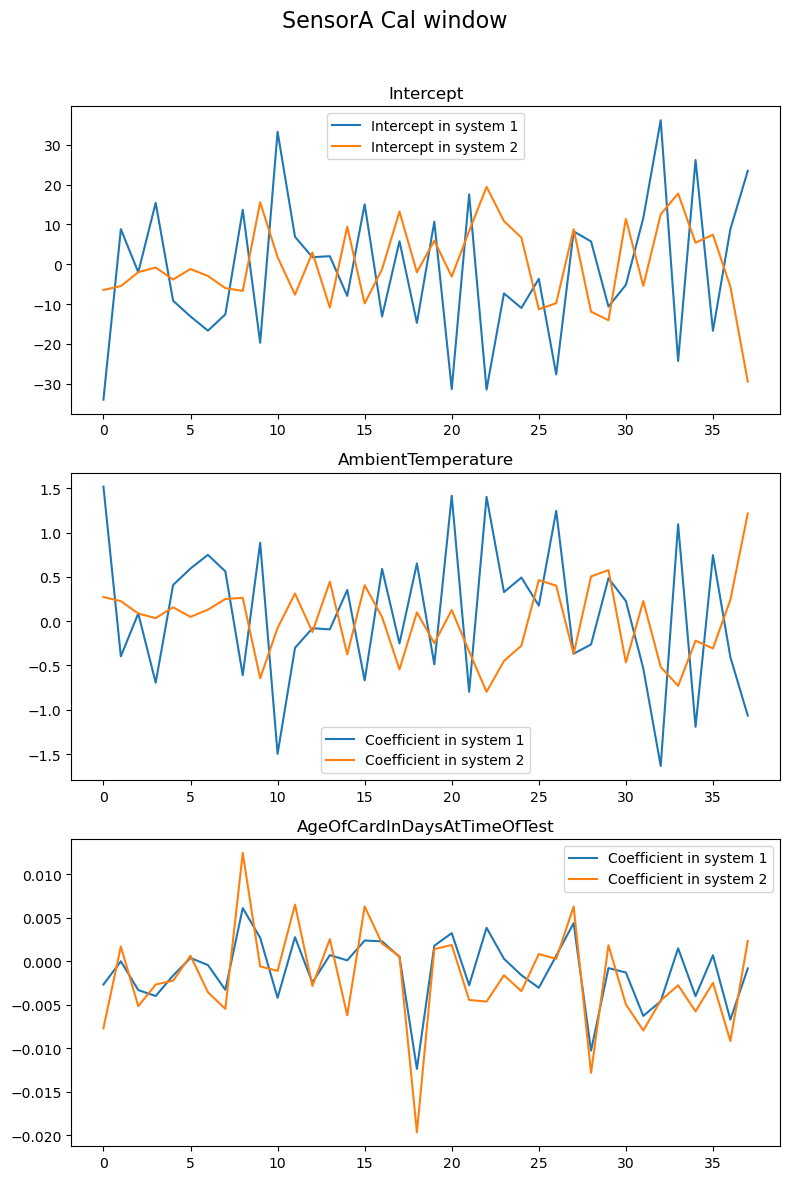

In [71]:
coefficent_visualization(A1_cal_window_funct_reg,A2_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],range(1,39),"SensorA Cal window")


##### Blood

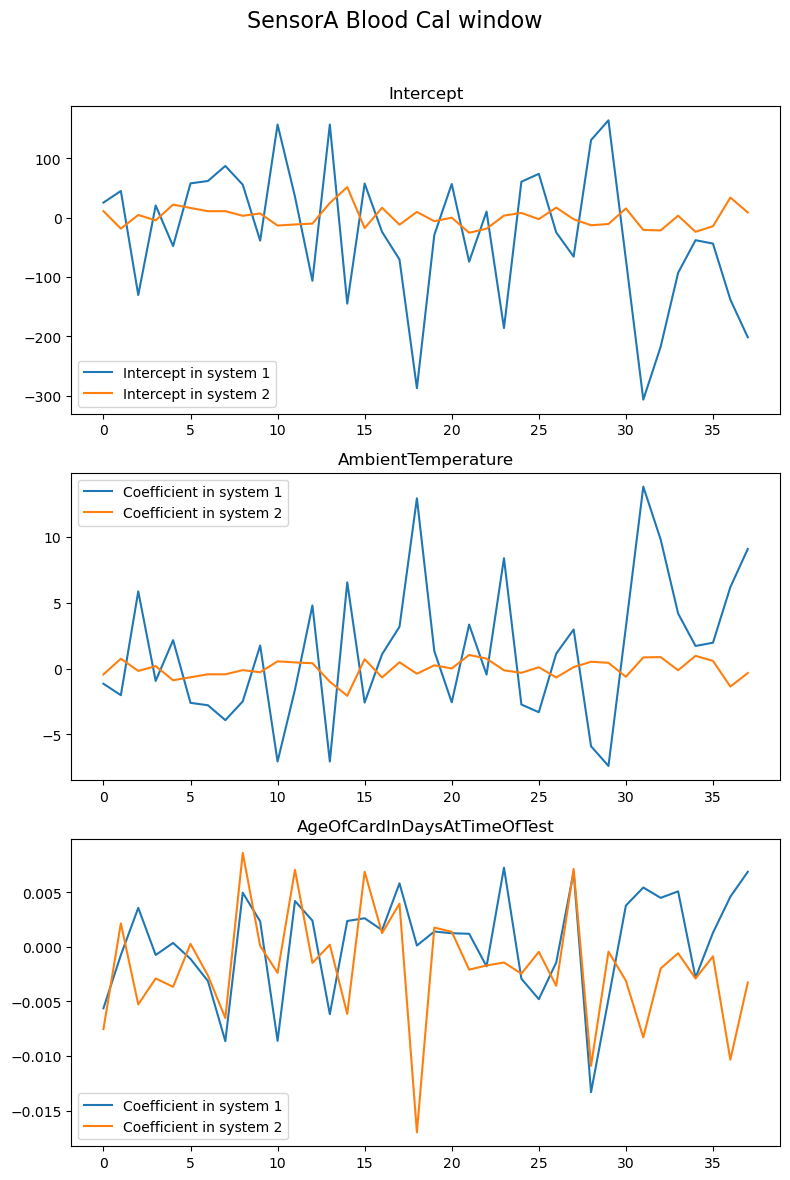

In [72]:
coefficent_visualization(A1_blood_cal_window_funct_reg,A2_blood_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],range(1,39),"SensorA Blood Cal window")


##### Aqueous

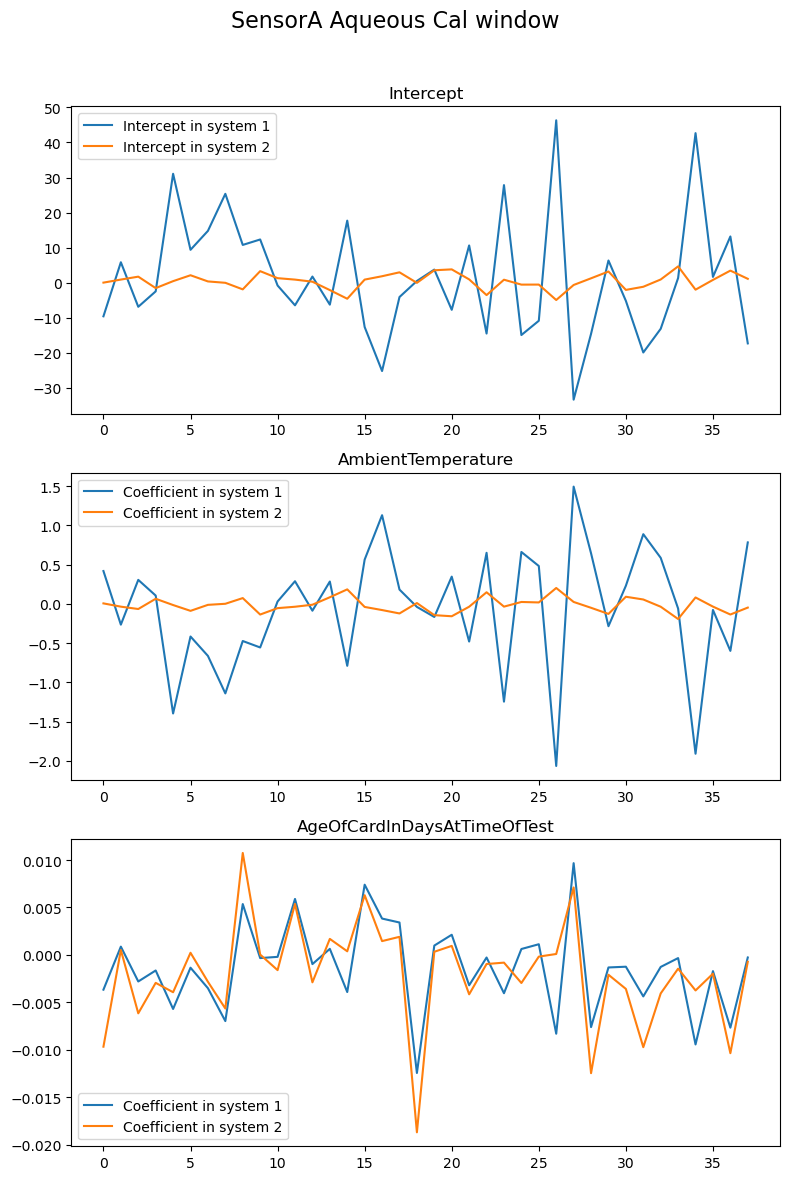

In [73]:
coefficent_visualization(A1_aqueous_cal_window_funct_reg,A2_aqueous_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],range(1,39),"SensorA Aqueous Cal window")


#### Sensor B

##### Blood

As the result show above, the value at time point 89 way higher than others. And also the first time point is also larger than others; Same case in both systems. So for the convenience of visualization, we remove these points.



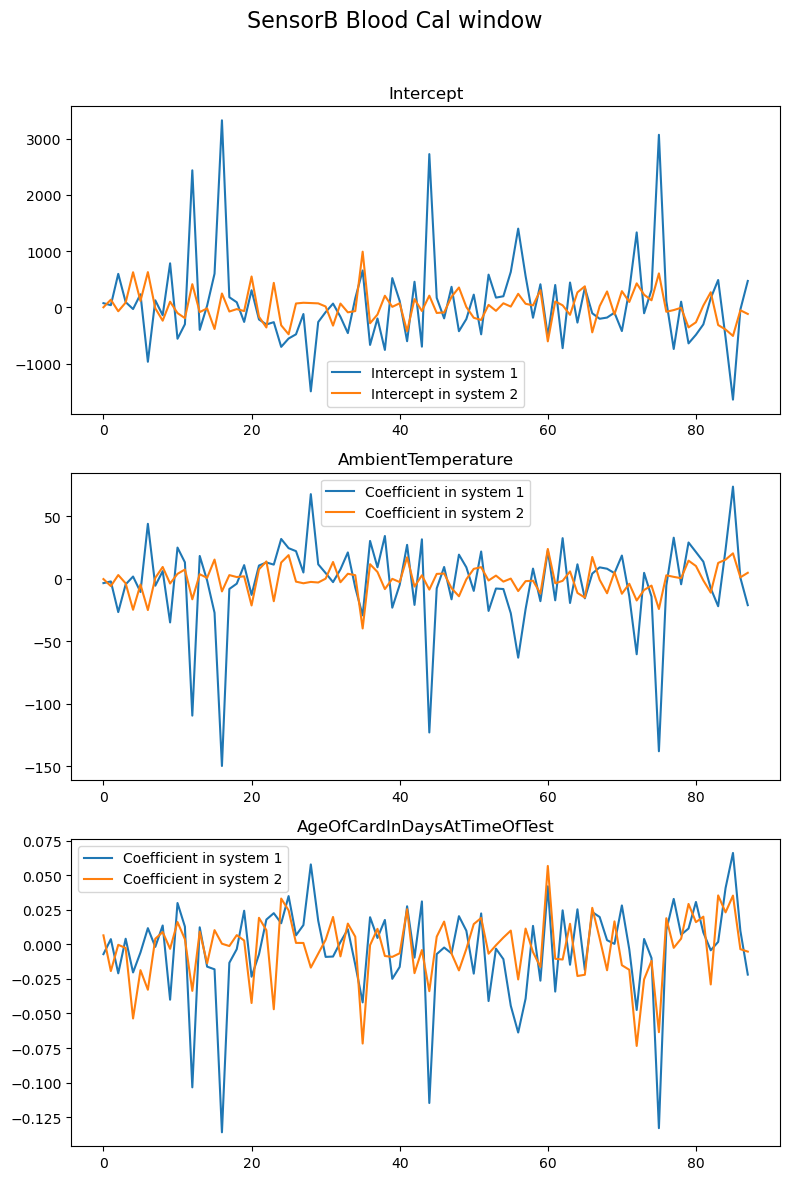

In [74]:
coefficent_visualization(B1_blood_cal_window_funct_reg,B2_blood_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],range(1,89),"SensorB Blood Cal window")


##### Aqueous

As the result show above, the value at time point 89 way higher than others. And also the first time point is also larger than others; Same case in both systems. So for the convenience of visualization, we remove these points.



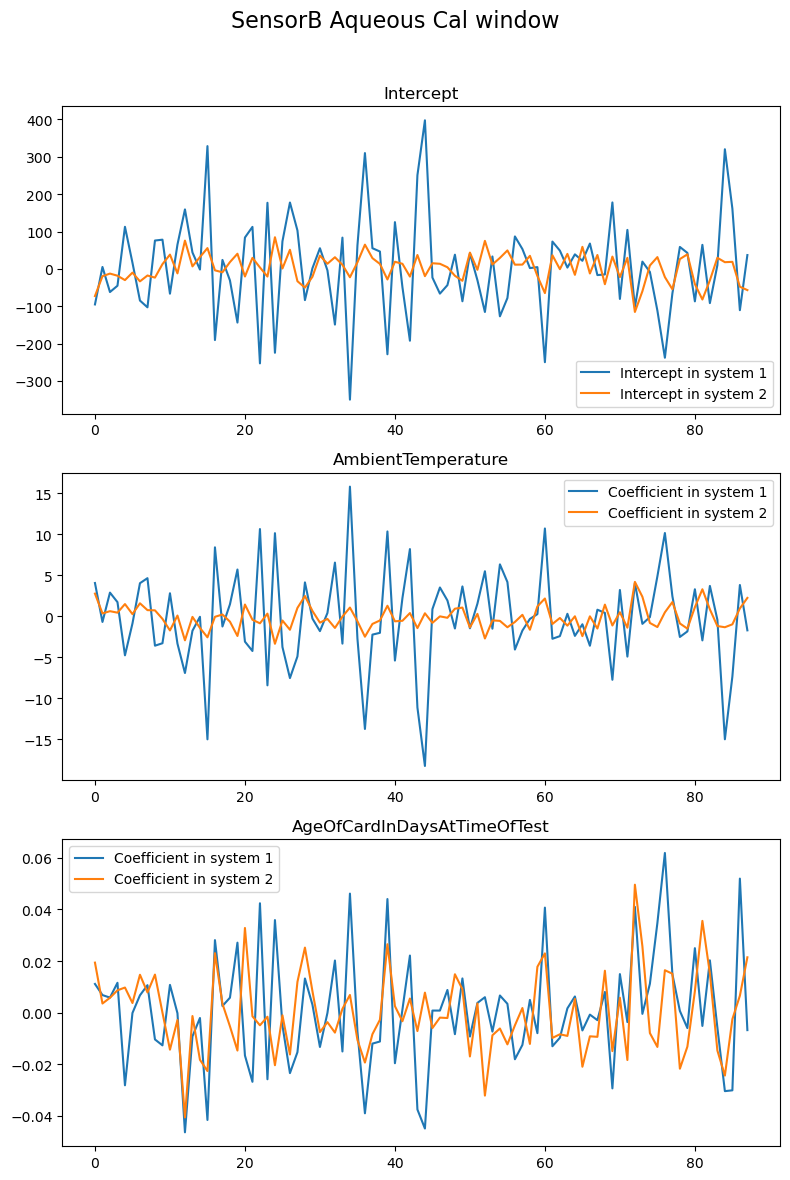

In [75]:
coefficent_visualization(B1_aqueous_cal_window_funct_reg,B2_aqueous_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],range(1,89),"SensorB Aqueous Cal window")


### Sample window

#### Sensor A


As the result show above, The first time point is also larger than others
* Same case in both systems.
* Same case in different Fluid Type

So for the convenience of visualization, we remove this point.

##### General

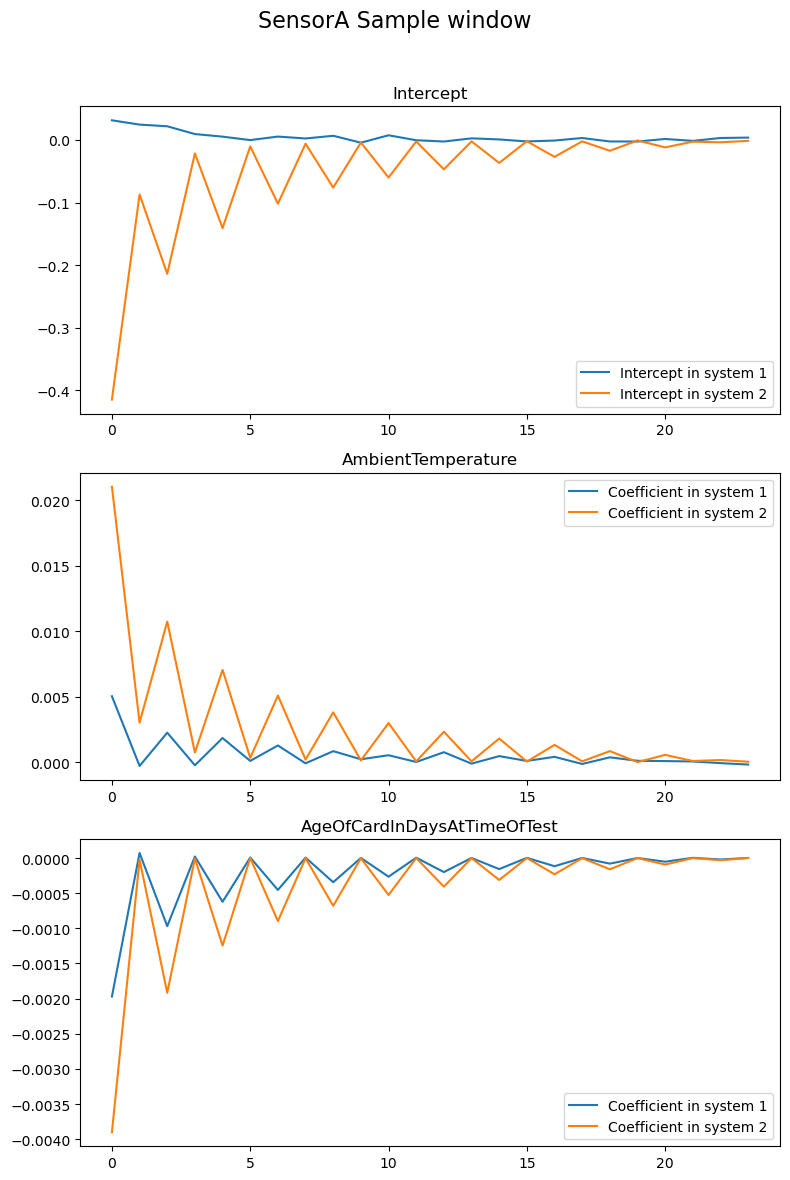

In [76]:
coefficent_visualization(A1_sample_window_funct_reg, A2_sample_window_funct_reg, ["AmbientTemperature", "AgeOfCardInDaysAtTimeOfTest"], range(1,25), "SensorA Sample window")


##### Blood

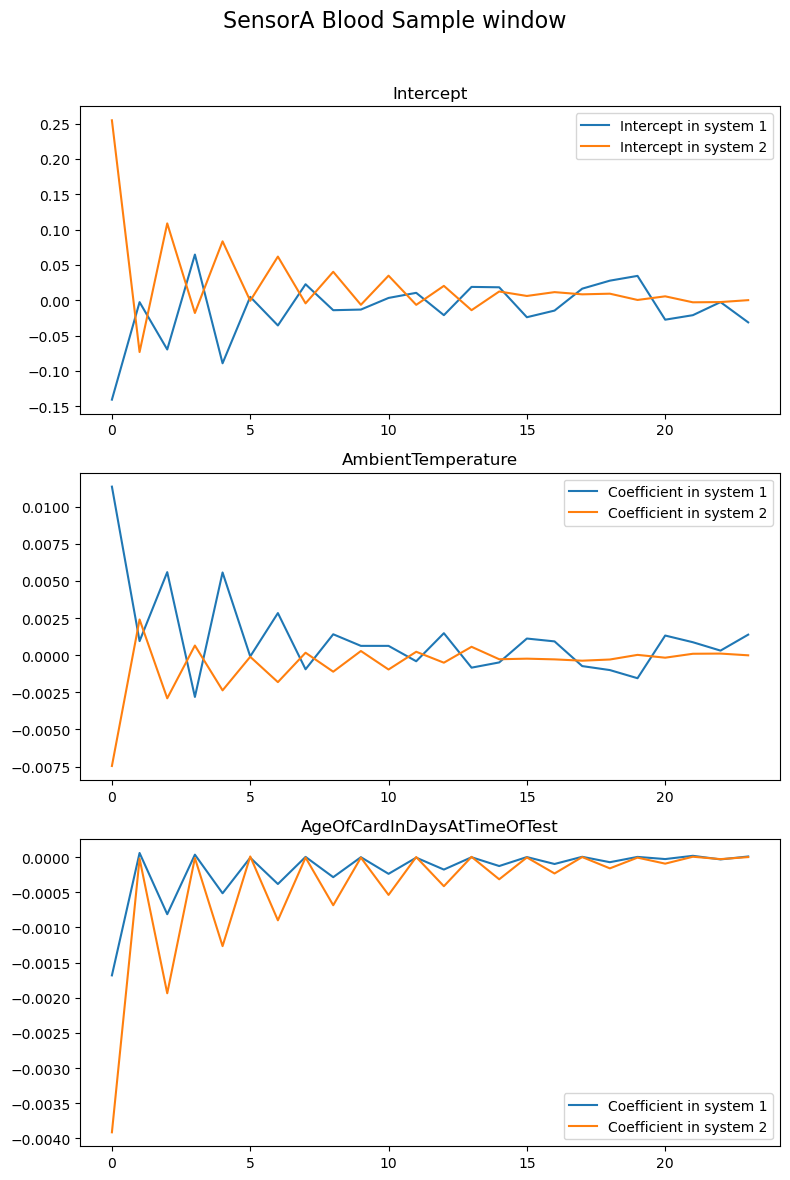

In [77]:
coefficent_visualization(A1_blood_sample_window_funct_reg, A2_blood_sample_window_funct_reg, ["AmbientTemperature", "AgeOfCardInDaysAtTimeOfTest"], range(1, 25), "SensorA Blood Sample window")

##### Aqueous

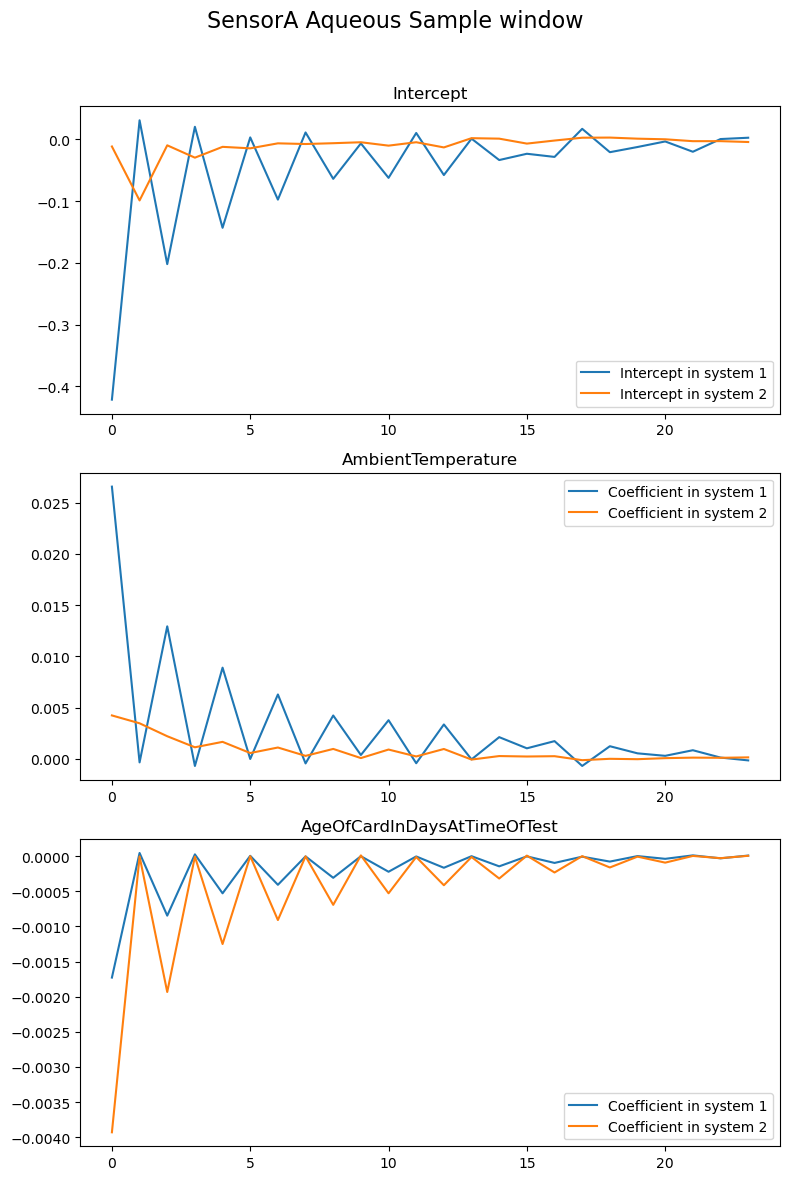

In [78]:
coefficent_visualization(A1_aqueous_sample_window_funct_reg, A2_aqueous_sample_window_funct_reg, ["AmbientTemperature", "AgeOfCardInDaysAtTimeOfTest"], range(1, 25), "SensorA Aqueous Sample window")


#### Sensor B

As the result show above, the value at time point 19 is significantly greater than the rest of the data. And the first time point is also larger than others;

Same case in both systems. So for the convenience of visualization, we remove these points.



##### Blood

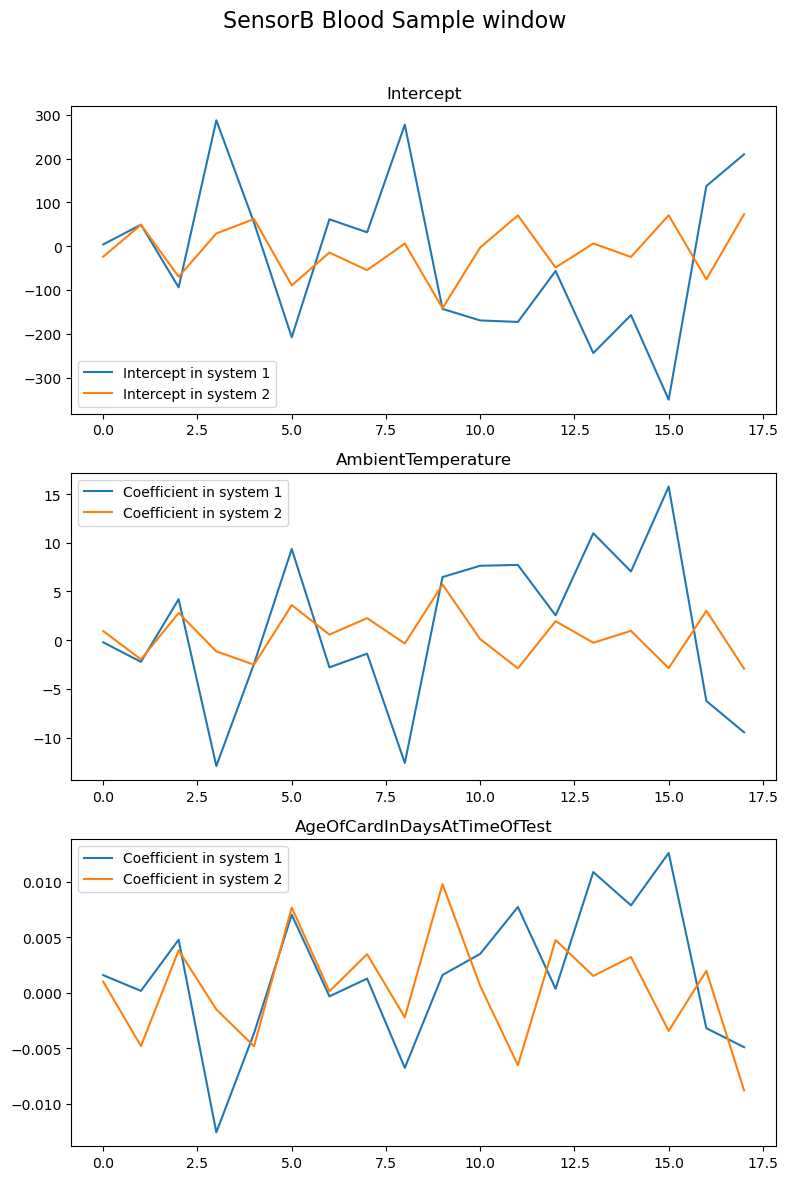

In [79]:
coefficent_visualization(B1_blood_sample_window_funct_reg, B2_blood_sample_window_funct_reg, ["AmbientTemperature", "AgeOfCardInDaysAtTimeOfTest"], range(1, 19), "SensorB Blood Sample window")

##### Aqueous

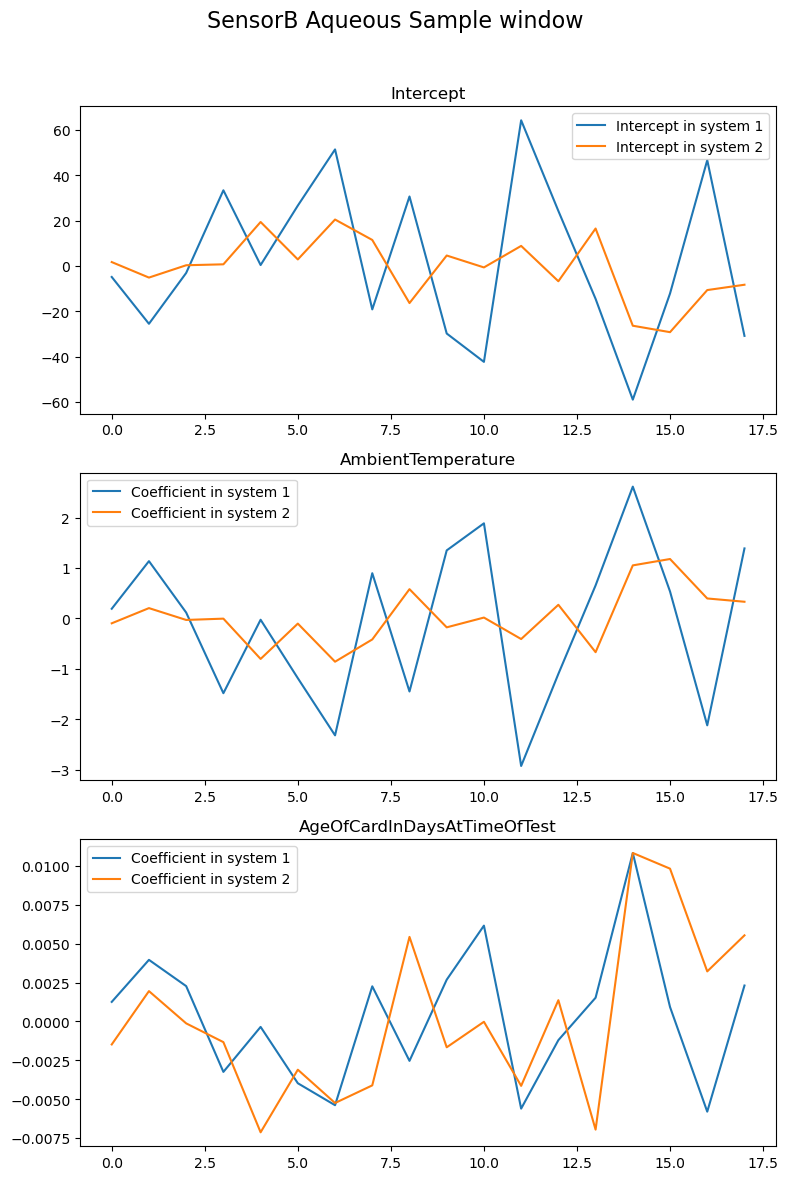

In [80]:
coefficent_visualization(B1_aqueous_sample_window_funct_reg, B2_aqueous_sample_window_funct_reg, ["AmbientTemperature", "AgeOfCardInDaysAtTimeOfTest"], range(1, 19), "SensorB Aqueous Sample window")
